## 0. Goal
Run VAE first to reduce spectrogram dimensions from 128*128 to 32 latent features. Then run UMAP and HDBSCAN. <br>
Use Goffinet spectrogramming and VAE network. Use fixed parameters. <br>
Run one bird at a time

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm, pickle
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import silhouette_score
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import calinski_harabasz_score

plt.rcParams['pdf.fonttype'] = 42 

In [2]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import hopkins2
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)
importlib.reload(hopkins2)

<module 'hopkins2' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/hopkins2.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [4]:
fd_z4 = '/mnt/z4'
bd = 'pair5RigCCU29'
pairID = 'pair5CU29CU55'
fd_base = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'Figures', pairID, 'CompoundSyl', bd, 'pairwiseCorre', 'prim_VAE')
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clim = [1.5,7]
# what syllable to analyze
syl = ['c']
sylStr = ''.join(syl)
# the default color list
col_list = ['#e41a1c','#a65628','#4daf4a','#984ea3','#ff7f00','#f781bf','#377eb8','#737373']
# what input dataset to use
# rn = 'spec_goffinet_nn_256_176'
rn = 'spec_goffinet_nn_256_236'
# size of the spectrogram windows
X_SHAPE = [128, 128]

In [5]:
fd_save = os.path.join(fd_base, 'UMAPonVAE7', sylStr, rn)
if not os.path.exists(fd_save):
    os.makedirs(fd_save)
print(fd_save)

/mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/CompoundSyl/pair5RigCCU29/pairwiseCorre/prim_VAE/UMAPonVAE7/c/spec_goffinet_nn_256_236


In [6]:
# paramteres for UMAP and HDBSCAN
param_umap = {'n_components':2, 'n_neighbors':25, 'min_dist':0, 'metric':'cosine'}
param_hdbscan = {'min_cluster_size_frac':0.05, 'min_samples': 20, 'select_method':'leaf'}

## 2. Train VAE, obtain latent features

In [7]:
print(f'Processing for {bd} {rn}...')
print(f'Save results to {fd_save}')
run_name = f'spec_goffinet_nn_256_236'
## load spectrograms and meta info
fn_spec = os.path.join(fd_base, 'Spectrogram', 'c', f'{bd}.c.{run_name}.h5')
fn_info = os.path.join(fd_base, 'Spectrogram', 'c', f'{bd}.c.{run_name}.info.csv')
with h5py.File(fn_spec, 'r') as f:
    spec_win_all = f['spec_win_all'][:]  #

info = pd.read_csv(fn_info, index_col=0)

print(spec_win_all.shape, info.shape)

Processing for pair5RigCCU29 spec_goffinet_nn_256_236...
Save results to /mnt/z4/zz367/EphysMONAO/Analyzed/Figures/pair5CU29CU55/CompoundSyl/pair5RigCCU29/pairwiseCorre/prim_VAE/UMAPonVAE7/c/spec_goffinet_nn_256_236
(8187, 128, 128) (8187, 7)


In [8]:
# train VAE network
# create dataloader from h5 file
train_data = vae_goffinet.SpecDataset(fn_spec)
# set a random seed
g = torch.Generator()
g.manual_seed(42)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, generator=g)  # set shuffle to true
loaders = {'train':train_dataloader, 'test':train_dataloader}

# init VAE model then train
model = vae_goffinet.VAE(save_dir=fd_save)
model.train_loop(loaders, epochs=51, test_freq=None, vis_freq=None, save_freq=10)

# OR load previously trained model
# for training see ZZp3_UMAPonVAE_v1.ipynb
# fn_model = os.path.join(fd_save, f'{bd}_checkpoint_final.tar')
# model = vae_goffinet.VAE(save_dir=fd_save)
# model.load_state(fn_model)

Training: epochs 0 to 50
Training set: 8187
Test set: 8187


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0 Average loss: 14031.5311
Epoch: 1 Average loss: 1205.7433
Epoch: 2 Average loss: 957.7384
Epoch: 3 Average loss: 847.5138
Epoch: 4 Average loss: 749.2490
Epoch: 5 Average loss: 663.4935
Epoch: 6 Average loss: 607.1477
Epoch: 7 Average loss: 571.0618
Epoch: 8 Average loss: 547.3606
Epoch: 9 Average loss: 521.2986
Epoch: 10 Average loss: 516.9495
Epoch: 11 Average loss: 477.9406
Epoch: 12 Average loss: 461.6326
Epoch: 13 Average loss: 445.4231
Epoch: 14 Average loss: 424.1390
Epoch: 15 Average loss: 427.8750
Epoch: 16 Average loss: 406.7826
Epoch: 17 Average loss: 395.2639
Epoch: 18 Average loss: 386.7291
Epoch: 19 Average loss: 388.0480
Epoch: 20 Average loss: 378.3628
Epoch: 21 Average loss: 366.5905
Epoch: 22 Average loss: 376.6982
Epoch: 23 Average loss: 361.2537
Epoch: 24 Average loss: 350.5500
Epoch: 25 Average loss: 341.9272
Epoch: 26 Average loss: 340.7500
Epoch: 27 Average loss: 334.7890
Epoch: 28 Average loss: 324.0740
Epoch: 29 Average loss: 329.3763
Epoch: 30 Average

In [9]:
## Obtain latent representation
train_data = vae_goffinet.SpecDataset(fn_spec)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False, num_workers=4)  # set shuffle to false to match the order in id_pd

# loop through dataloader, obtain model latent space
latent_m = np.zeros((info.shape[0], 32))
latent_d = np.zeros((info.shape[0], 32))
recon = np.zeros((info.shape[0], X_SHAPE[0], X_SHAPE[1]))
model.eval()
count = 0
for i, data in tqdm.tqdm(enumerate(train_dataloader)):
    data = data.to('cuda:0')
    with torch.no_grad():
        _, _, rec, mu, d = model.forwardZZ(data, return_latent_rec=True)
        a = rec.shape[0]
        latent_m[count:(count+a),:] = mu
        latent_d[count:(count+a),:] = d
        recon[count:(count+a),:,:] = rec
        count += a

# save the latent representations
fn_latentM = os.path.join(fd_save, 'latentM.csv')
np.savetxt(fn_latentM, latent_m, delimiter=',')
fn_latentD = os.path.join(fd_save, 'latentD.csv')
np.savetxt(fn_latentD, latent_d, delimiter=',')
print(latent_m.shape)

128it [00:09, 13.98it/s]


(8187, 32)


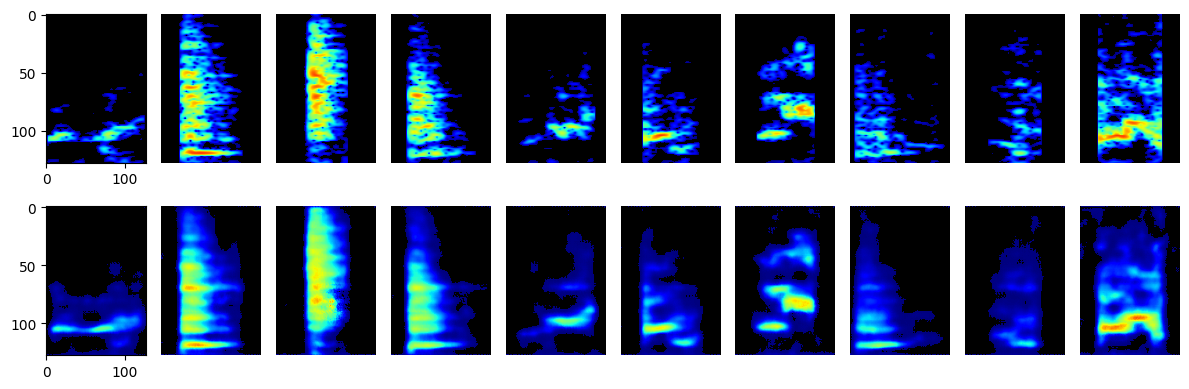

In [11]:
## check recontruction accuracy (optional)
# plot some random samples
fig, ax = plt.subplots(2, 10, figsize=[12,4])
random.seed(1118)
random_i = random.sample(list(range(recon.shape[0])), 10)
with h5py.File(fn_spec, 'r') as file:
    for ii in range(10):
        spec = train_data[random_i[ii],:,:].numpy()
        ax[0][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        spec = recon[random_i[ii],:,:]
        ax[1][ii].imshow(np.flip(spec, 0), aspect='auto', vmin=0, vmax=1, cmap=custom_cmap)
        if ii>0:
            ax[0][ii].axis('off')
            ax[1][ii].axis('off')
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, 'reconstructed_spectrogram.pdf')
fig.savefig(fn_fig)


## 3. Run UMAP/HDBSCAN

In [12]:
# fn_info = os.path.join(fd_data, bd, 'Spectrogram2', sylStr, f'{bd}.{sylStr}.{rn}.info.csv')
info = pd.read_csv(fn_info, index_col=0)

In [13]:
# read latent features
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(8187, 32)

In [14]:
# add latent_m to the embedding data frame
embed = info.copy()
for ii in range(latent_m.shape[1]):
    embed[f'vae{ii}'] = latent_m[:,ii]

### UMAP

In [15]:
## run UMAP 
print(param_umap)
umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                              metric=param_umap['metric'], random_state=1118, verbose=True)
res = umap_model.fit_transform(latent_m)

# add UMAP embedding to the dataframe
for jj in range(res.shape[1]):
    embed[f'umap{jj+1}'] = res[:,jj]

{'n_components': 2, 'n_neighbors': 25, 'min_dist': 0, 'metric': 'cosine'}
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Sun Sep 21 20:11:56 2025 Construct fuzzy simplicial set
Sun Sep 21 20:11:56 2025 Finding Nearest Neighbors
Sun Sep 21 20:11:56 2025 Building RP forest with 10 trees


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Sun Sep 21 20:11:59 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sun Sep 21 20:12:07 2025 Finished Nearest Neighbor Search
Sun Sep 21 20:12:08 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Sep 21 20:12:23 2025 Finished embedding


In [16]:
# save the UMAP model for later usage
fn_umap = os.path.join(fd_save, f'UMAPmodel_{bd}.p')
pickle.dump(umap_model, open(fn_umap, 'wb'))

Sun Sep 21 20:12:24 2025 Worst tree score: 0.91058996
Sun Sep 21 20:12:24 2025 Mean tree score: 0.91486503
Sun Sep 21 20:12:24 2025 Best tree score: 0.92146085
Sun Sep 21 20:12:25 2025 Forward diversification reduced edges from 204675 to 63277
Sun Sep 21 20:12:27 2025 Reverse diversification reduced edges from 63277 to 63277
Sun Sep 21 20:12:29 2025 Degree pruning reduced edges from 68116 to 68116
Sun Sep 21 20:12:29 2025 Resorting data and graph based on tree order
Sun Sep 21 20:12:29 2025 Building and compiling search function


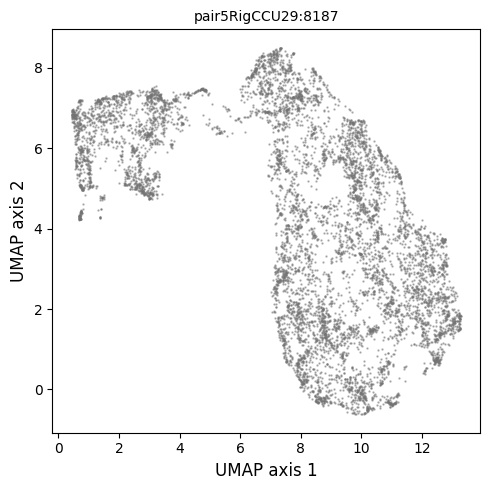

In [17]:
## plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for si, ss in enumerate(syl):
    embed_s = embed[embed['label']==ss]
    ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.5, alpha=0.5, c='#737373')
    # add syl label
    # ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), ss, fontsize=14)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig =os.path.join(fd_save, f'{bd}.UMAPonVAE.embedding.pdf')
fig.savefig(fn_fig)

### HDBSCAN clustering

In [23]:
800 / res.shape[0]

0.06148643455537622

In [24]:
## HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
                            cluster_selection_method=param_hdbscan['select_method'], prediction_data=True)
# clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=20, 
#                             cluster_selection_method='leaf')
# clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
clusterer.fit(res)
embed['hdbscan_cluster'] = clusterer.labels_ + 1    # no clustering is label 0
embed['hdbscan_prob'] = clusterer.probabilities_

# save embedding and clustering 
fn_embed = os.path.join(fd_save, f'{bd}.{rn}.embedding.csv')
embed.to_csv(fn_embed)

# what's the fraction that's not clustered
unc_f = embed[embed['hdbscan_cluster']==0].shape[0] / embed.shape[0]
print(f'The fraction that are not clustered: {unc_f:.4f}')
num_c = max(embed['hdbscan_cluster'])
print(f'Total number of clusters: {num_c}')

The fraction that are not clustered: 0.3539
Total number of clusters: 6


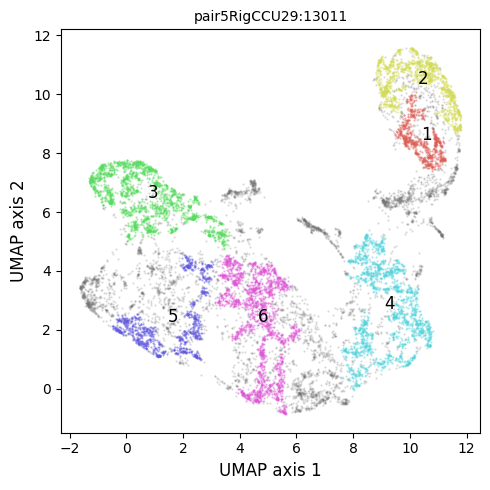

In [25]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(embed['hdbscan_cluster']))
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(0, max(embed['hdbscan_cluster'])+1):
    embed_s = embed[embed['hdbscan_cluster']==hi]
    if hi==0:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s['umap1'], embed_s['umap2'], s=0.3, alpha=0.5, color=col_long[hi-1])
        # add syl label
        ax.text(np.mean(embed_s['umap1']), np.mean(embed_s['umap2']), hi, fontsize=12)
ax.set_title(f'{bd}:{embed.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [18]:
# save HDBSCAN model for future use
fn_cluster = os.path.join(fd_save, f'HDBSCANmodel_{bd}.p')
pickle.dump(clusterer, open(fn_cluster, 'wb'))

In [19]:
# save the color list as well
col_long_np = np.array(col_long)
fn_col = os.path.join(fd_save, 'color.txt')
np.savetxt(fn_col, col_long_np, delimiter=',')

### Quantify clustering quality

In [20]:
## Quantify clustering tendency
# in UMAP space
hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
print(f'Hopkins metric in UMAP: {hpk1:.4f}')
# in VAE space
hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
print(f'Hopkins metric in VAE: {hpk2:.4f}')

## Quantify clustering quality with Silhoutte score
# in UMAP space
sil1 = silhouette_score(res, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
# in VAE space
sil2 = silhouette_score(latent_m, embed['hdbscan_cluster'], random_state=1118, metric='euclidean')
print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

# Calinski–Harabasz (CH) Index
cah1 = calinski_harabasz_score(res, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
cah2 = calinski_harabasz_score(latent_m, embed['hdbscan_cluster'])
print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

# save data to the master data frame
metrics = pd.DataFrame([{'birdID':bd, 'run_name':rn, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                     'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])

Hopkins metric in UMAP: 0.9611
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: 0.3377
HDBSCAN Silhouette score in VAE: 0.0205
Calinski–Harabasz index in UMAP: 14121.4833
Calinski–Harabasz index in VAE: 893.1422


In [21]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair5RigCCU29,spec_goffinet_nn_256_176,7,0.098451,"[0.41028190249251084, 0.4461921355022681, 0.36...",0.961081,0.860745,0.337655,0.020477,14121.483309,893.142187,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


## 4. Simulate the random datasets

In [35]:
# number of trials to simulate
n = 200

In [36]:
# load the real dataset
fn_latentM = os.path.join(fd_save, 'latentM.csv')
latent_m = np.loadtxt(fn_latentM, delimiter=',')
latent_m.shape

(23240, 32)

In [37]:
 # estimated mean and variance
mu = latent_m.mean(axis=0)                        # empirical mean  (shape: 32,)
Sigma  = np.cov(latent_m, rowvar=False, ddof=1)

In [38]:
# save metrics in a master dataframe
metrics = pd.DataFrame()
np.random.seed(1118)
for i in range(n):
# for i in range(2):
    rng = np.random.default_rng()  
    latent_rd = rng.multivariate_normal(mean=mu, cov=Sigma, size=latent_m.shape[0], method='cholesky')
    
    # then run UMAP and HDBSCAN exactly as for real datasets
    ## run UMAP 
    umap_model = umap.UMAP(n_neighbors=param_umap['n_neighbors'], n_components=param_umap['n_components'], min_dist=param_umap['min_dist'], 
                                                  metric=param_umap['metric'], random_state=1118, verbose=True)
    res = umap_model.fit_transform(latent_rd)

    ## HDBSCAN clustering
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=int(res.shape[0]* param_hdbscan['min_cluster_size_frac']), min_samples=param_hdbscan['min_samples'], 
    #                             cluster_selection_method=param_hdbscan['select_method'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=800, min_samples=20, 
                                cluster_selection_method='leaf')
    # clusterer = hdbscan.HDBSCAN(min_cluster_size=200, min_samples=20)
    clusterer.fit(res)
    
    labs = clusterer.labels_; 
    # what's the fraction that's not clustered
    unc_f = labs[labs==-1].shape[0] / labs.shape[0]
    print(f'The fraction that are not clustered: {unc_f:.4f}')
    num_c = max(labs+1)
    print(f'Total number of clusters: {num_c}')
    
    if num_c==0:
        continue

    ## Quantify clustering tendency
    # in UMAP space
    hpk1 = hopkins2.hopkins_statistic(res, rng=1992)
    print(f'Hopkins metric in UMAP: {hpk1:.4f}')
    # in VAE space
    hpk2 = hopkins2.hopkins_statistic(latent_m, rng=1992)
    print(f'Hopkins metric in VAE: {hpk2:.4f}')

    ## Quantify clustering quality with Silhoutte score
    # in UMAP space
    sil1 = silhouette_score(res, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in UMAP: {sil1:.4f}')
    # in VAE space
    sil2 = silhouette_score(latent_m, labs, random_state=1118, metric='euclidean')
    print(f'HDBSCAN Silhouette score in VAE: {sil2:.4f}')

    # Calinski–Harabasz (CH) Index
    cah1 = calinski_harabasz_score(res, labs)
    print(f'Calinski–Harabasz index in UMAP: {cah1:.4f}')
    cah2 = calinski_harabasz_score(latent_m, labs)
    print(f'Calinski–Harabasz index in VAE: {cah2:.4f}')

    # save data to the master data frame
    row = pd.DataFrame([{'birdID':bd, 'run_id':i, 'num_cluster':num_c, 'frac_unclustered':unc_f, 'cluster_persist':clusterer.cluster_persistence_, 'hopkins_umap':hpk1, 
                         'hopkins_vae':hpk2, 'silhouette_umap':sil1, 'silhouette_vae':sil2, 'calinski_umap':cah1, 'calinski_vae':cah2, 'param_umap':param_umap, 'param_hdbscan':param_hdbscan}])
    metrics = pd.concat([metrics, row], ignore_index=True)

/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:13:50 2025 Construct fuzzy simplicial set
Fri Jun 20 16:13:50 2025 Finding Nearest Neighbors
Fri Jun 20 16:13:50 2025 Building RP forest with 13 trees
Fri Jun 20 16:13:50 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:13:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:13:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:14:00 2025 Finished embedding
The fraction that are not clustered: 0.7396
Total number of clusters: 5
Hopkins metric in UMAP: 0.8494
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2913
HDBSCAN Silhouette score in VAE: -0.0084
Calinski–Harabasz index in UMAP: 835.7681
Calinski–Harabasz index in VAE: 1.1973
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:14:14 2025 Construct fuzzy simplicial set
Fri Jun 20 16:14:14 2025 Finding Nearest Neighbors
Fri Jun 20 16:14:14 2025 Building RP forest with 13 trees
Fri Jun 20 16:14:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:14:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:14:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:14:24 2025 Finished embedding
The fraction that are not clustered: 0.8024
Total number of clusters: 4
Hopkins metric in UMAP: 0.8811
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2914
HDBSCAN Silhouette score in VAE: -0.0053
Calinski–Harabasz index in UMAP: 841.4252
Calinski–Harabasz index in VAE: 0.8146
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:14:36 2025 Construct fuzzy simplicial set
Fri Jun 20 16:14:36 2025 Finding Nearest Neighbors
Fri Jun 20 16:14:36 2025 Building RP forest with 13 trees
Fri Jun 20 16:14:37 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:14:37 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:14:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:14:47 2025 Finished embedding
The fraction that are not clustered: 0.7310
Total number of clusters: 4
Hopkins metric in UMAP: 0.8646
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2676
HDBSCAN Silhouette score in VAE: -0.0026
Calinski–Harabasz index in UMAP: 708.4169
Calinski–Harabasz index in VAE: 1.3661
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:14:59 2025 Construct fuzzy simplicial set
Fri Jun 20 16:14:59 2025 Finding Nearest Neighbors
Fri Jun 20 16:14:59 2025 Building RP forest with 13 trees
Fri Jun 20 16:14:59 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:15:00 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:15:00 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:15:09 2025 Finished embedding
The fraction that are not clustered: 0.6831
Total number of clusters: 4
Hopkins metric in UMAP: 0.8709
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1912
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 1307.3597
Calinski–Harabasz index in VAE: 1.2281
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:15:20 2025 Construct fuzzy simplicial set
Fri Jun 20 16:15:20 2025 Finding Nearest Neighbors
Fri Jun 20 16:15:20 2025 Building RP forest with 13 trees
Fri Jun 20 16:15:20 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:15:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:15:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:15:30 2025 Finished embedding
The fraction that are not clustered: 0.6489
Total number of clusters: 5
Hopkins metric in UMAP: 0.8531
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2272
HDBSCAN Silhouette score in VAE: -0.0090
Calinski–Harabasz index in UMAP: 1309.0941
Calinski–Harabasz index in VAE: 0.6905
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:15:42 2025 Construct fuzzy simplicial set
Fri Jun 20 16:15:42 2025 Finding Nearest Neighbors
Fri Jun 20 16:15:42 2025 Building RP forest with 13 trees
Fri Jun 20 16:15:42 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:15:43 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:15:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:15:52 2025 Finished embedding
The fraction that are not clustered: 0.7790
Total number of clusters: 3
Hopkins metric in UMAP: 0.8818
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2227
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1124.3817
Calinski–Harabasz index in VAE: 1.1931
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:16:04 2025 Construct fuzzy simplicial set
Fri Jun 20 16:16:04 2025 Finding Nearest Neighbors
Fri Jun 20 16:16:04 2025 Building RP forest with 13 trees
Fri Jun 20 16:16:04 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:16:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:16:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:16:14 2025 Finished embedding
The fraction that are not clustered: 0.6448
Total number of clusters: 3
Hopkins metric in UMAP: 0.8382
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1782
HDBSCAN Silhouette score in VAE: -0.0079
Calinski–Harabasz index in UMAP: 813.9041
Calinski–Harabasz index in VAE: 0.7107
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:16:26 2025 Construct fuzzy simplicial set
Fri Jun 20 16:16:26 2025 Finding Nearest Neighbors
Fri Jun 20 16:16:26 2025 Building RP forest with 13 trees
Fri Jun 20 16:16:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:16:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:16:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:16:36 2025 Finished embedding
The fraction that are not clustered: 0.7330
Total number of clusters: 3
Hopkins metric in UMAP: 0.8769
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2136
HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1002.5675
Calinski–Harabasz index in VAE: 0.9513
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:16:47 2025 Construct fuzzy simplicial set
Fri Jun 20 16:16:47 2025 Finding Nearest Neighbors
Fri Jun 20 16:16:47 2025 Building RP forest with 13 trees
Fri Jun 20 16:16:48 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:16:49 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:16:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:16:58 2025 Finished embedding
The fraction that are not clustered: 0.7586
Total number of clusters: 3
Hopkins metric in UMAP: 0.8716
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2200
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 982.1233
Calinski–Harabasz index in VAE: 1.0380
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:17:10 2025 Construct fuzzy simplicial set
Fri Jun 20 16:17:10 2025 Finding Nearest Neighbors
Fri Jun 20 16:17:10 2025 Building RP forest with 13 trees
Fri Jun 20 16:17:10 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:17:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:17:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:17:20 2025 Finished embedding
The fraction that are not clustered: 0.7442
Total number of clusters: 3
Hopkins metric in UMAP: 0.8810
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2186
HDBSCAN Silhouette score in VAE: -0.0062
Calinski–Harabasz index in UMAP: 945.4811
Calinski–Harabasz index in VAE: 0.8684
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:17:32 2025 Construct fuzzy simplicial set
Fri Jun 20 16:17:32 2025 Finding Nearest Neighbors
Fri Jun 20 16:17:32 2025 Building RP forest with 13 trees
Fri Jun 20 16:17:32 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:17:33 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:17:33 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:17:42 2025 Finished embedding
The fraction that are not clustered: 0.6988
Total number of clusters: 6
Hopkins metric in UMAP: 0.8615
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2820
HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 1044.4113
Calinski–Harabasz index in VAE: 0.8722
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:17:53 2025 Construct fuzzy simplicial set
Fri Jun 20 16:17:53 2025 Finding Nearest Neighbors
Fri Jun 20 16:17:53 2025 Building RP forest with 13 trees
Fri Jun 20 16:17:54 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:17:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:17:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:18:04 2025 Finished embedding
The fraction that are not clustered: 0.7980
Total number of clusters: 3
Hopkins metric in UMAP: 0.8471
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1986
HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 1504.0419
Calinski–Harabasz index in VAE: 0.8935
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:18:16 2025 Construct fuzzy simplicial set
Fri Jun 20 16:18:16 2025 Finding Nearest Neighbors
Fri Jun 20 16:18:16 2025 Building RP forest with 13 trees
Fri Jun 20 16:18:16 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:18:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:18:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:18:26 2025 Finished embedding
The fraction that are not clustered: 0.6247
Total number of clusters: 5
Hopkins metric in UMAP: 0.8496
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2063
HDBSCAN Silhouette score in VAE: -0.0074
Calinski–Harabasz index in UMAP: 1473.1493
Calinski–Harabasz index in VAE: 1.2598
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:18:37 2025 Construct fuzzy simplicial set
Fri Jun 20 16:18:37 2025 Finding Nearest Neighbors
Fri Jun 20 16:18:37 2025 Building RP forest with 13 trees
Fri Jun 20 16:18:37 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:18:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:18:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:18:47 2025 Finished embedding
The fraction that are not clustered: 0.4850
Total number of clusters: 6
Hopkins metric in UMAP: 0.8739
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2198
HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 1074.8133
Calinski–Harabasz index in VAE: 0.7973
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:18:58 2025 Construct fuzzy simplicial set
Fri Jun 20 16:18:58 2025 Finding Nearest Neighbors
Fri Jun 20 16:18:58 2025 Building RP forest with 13 trees
Fri Jun 20 16:18:58 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:18:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:18:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:19:08 2025 Finished embedding
The fraction that are not clustered: 0.6162
Total number of clusters: 5
Hopkins metric in UMAP: 0.8763
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2121
HDBSCAN Silhouette score in VAE: -0.0089
Calinski–Harabasz index in UMAP: 1355.5530
Calinski–Harabasz index in VAE: 0.9455
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:19:20 2025 Construct fuzzy simplicial set
Fri Jun 20 16:19:20 2025 Finding Nearest Neighbors
Fri Jun 20 16:19:20 2025 Building RP forest with 13 trees
Fri Jun 20 16:19:20 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:19:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:19:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:19:30 2025 Finished embedding
The fraction that are not clustered: 0.7103
Total number of clusters: 4
Hopkins metric in UMAP: 0.8837
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2174
HDBSCAN Silhouette score in VAE: -0.0069
Calinski–Harabasz index in UMAP: 1302.9121
Calinski–Harabasz index in VAE: 1.1076
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:19:42 2025 Construct fuzzy simplicial set
Fri Jun 20 16:19:42 2025 Finding Nearest Neighbors
Fri Jun 20 16:19:42 2025 Building RP forest with 13 trees
Fri Jun 20 16:19:42 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:19:43 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:19:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:19:52 2025 Finished embedding
The fraction that are not clustered: 0.6214
Total number of clusters: 6
Hopkins metric in UMAP: 0.8379
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2163
HDBSCAN Silhouette score in VAE: -0.0091
Calinski–Harabasz index in UMAP: 1340.6957
Calinski–Harabasz index in VAE: 1.4441
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:20:03 2025 Construct fuzzy simplicial set
Fri Jun 20 16:20:03 2025 Finding Nearest Neighbors
Fri Jun 20 16:20:03 2025 Building RP forest with 13 trees
Fri Jun 20 16:20:03 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:20:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:20:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:20:13 2025 Finished embedding
The fraction that are not clustered: 0.6735
Total number of clusters: 4
Hopkins metric in UMAP: 0.8549
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2124
HDBSCAN Silhouette score in VAE: -0.0034
Calinski–Harabasz index in UMAP: 1046.9297
Calinski–Harabasz index in VAE: 0.7128
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:20:25 2025 Construct fuzzy simplicial set
Fri Jun 20 16:20:25 2025 Finding Nearest Neighbors
Fri Jun 20 16:20:25 2025 Building RP forest with 13 trees
Fri Jun 20 16:20:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:20:26 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:20:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:20:35 2025 Finished embedding
The fraction that are not clustered: 0.6179
Total number of clusters: 4
Hopkins metric in UMAP: 0.8538
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1434
HDBSCAN Silhouette score in VAE: -0.0066
Calinski–Harabasz index in UMAP: 1456.5071
Calinski–Harabasz index in VAE: 0.8060
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:20:46 2025 Construct fuzzy simplicial set
Fri Jun 20 16:20:46 2025 Finding Nearest Neighbors
Fri Jun 20 16:20:46 2025 Building RP forest with 13 trees
Fri Jun 20 16:20:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:20:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:20:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:20:57 2025 Finished embedding
The fraction that are not clustered: 0.6545
Total number of clusters: 3
Hopkins metric in UMAP: 0.8760
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1803
HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 913.1738
Calinski–Harabasz index in VAE: 1.4155
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:21:08 2025 Construct fuzzy simplicial set
Fri Jun 20 16:21:08 2025 Finding Nearest Neighbors
Fri Jun 20 16:21:08 2025 Building RP forest with 13 trees
Fri Jun 20 16:21:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:21:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:21:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:21:18 2025 Finished embedding
The fraction that are not clustered: 0.7140
Total number of clusters: 5
Hopkins metric in UMAP: 0.8828
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2661
HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 1015.5684
Calinski–Harabasz index in VAE: 1.2724
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:21:30 2025 Construct fuzzy simplicial set
Fri Jun 20 16:21:30 2025 Finding Nearest Neighbors
Fri Jun 20 16:21:30 2025 Building RP forest with 13 trees
Fri Jun 20 16:21:30 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:21:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:21:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:21:40 2025 Finished embedding
The fraction that are not clustered: 0.5960
Total number of clusters: 5
Hopkins metric in UMAP: 0.8451
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1862
HDBSCAN Silhouette score in VAE: -0.0092
Calinski–Harabasz index in UMAP: 1695.3748
Calinski–Harabasz index in VAE: 1.0605
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:21:52 2025 Construct fuzzy simplicial set
Fri Jun 20 16:21:52 2025 Finding Nearest Neighbors
Fri Jun 20 16:21:52 2025 Building RP forest with 13 trees
Fri Jun 20 16:21:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:21:53 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:21:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:22:02 2025 Finished embedding
The fraction that are not clustered: 0.7179
Total number of clusters: 5
Hopkins metric in UMAP: 0.8824
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2685
HDBSCAN Silhouette score in VAE: -0.0100
Calinski–Harabasz index in UMAP: 1069.4178
Calinski–Harabasz index in VAE: 0.7712
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:22:13 2025 Construct fuzzy simplicial set
Fri Jun 20 16:22:13 2025 Finding Nearest Neighbors
Fri Jun 20 16:22:13 2025 Building RP forest with 13 trees
Fri Jun 20 16:22:13 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:22:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:22:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:22:24 2025 Finished embedding
The fraction that are not clustered: 0.5928
Total number of clusters: 4
Hopkins metric in UMAP: 0.8752
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1640
HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1349.1334
Calinski–Harabasz index in VAE: 1.0174
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:22:35 2025 Construct fuzzy simplicial set
Fri Jun 20 16:22:35 2025 Finding Nearest Neighbors
Fri Jun 20 16:22:35 2025 Building RP forest with 13 trees
Fri Jun 20 16:22:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:22:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:22:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:22:45 2025 Finished embedding
The fraction that are not clustered: 0.5362
Total number of clusters: 4
Hopkins metric in UMAP: 0.8482
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.0877
HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 2356.1601
Calinski–Harabasz index in VAE: 1.0087
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:22:57 2025 Construct fuzzy simplicial set
Fri Jun 20 16:22:57 2025 Finding Nearest Neighbors
Fri Jun 20 16:22:57 2025 Building RP forest with 13 trees
Fri Jun 20 16:22:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:22:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:22:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:23:07 2025 Finished embedding
The fraction that are not clustered: 0.6401
Total number of clusters: 5
Hopkins metric in UMAP: 0.8551
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2078
HDBSCAN Silhouette score in VAE: -0.0066
Calinski–Harabasz index in UMAP: 1333.3484
Calinski–Harabasz index in VAE: 0.8354
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:23:19 2025 Construct fuzzy simplicial set
Fri Jun 20 16:23:19 2025 Finding Nearest Neighbors
Fri Jun 20 16:23:19 2025 Building RP forest with 13 trees
Fri Jun 20 16:23:19 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:23:20 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:23:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:23:29 2025 Finished embedding
The fraction that are not clustered: 0.6249
Total number of clusters: 6
Hopkins metric in UMAP: 0.8741
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2286
HDBSCAN Silhouette score in VAE: -0.0074
Calinski–Harabasz index in UMAP: 1322.3761
Calinski–Harabasz index in VAE: 1.1462
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:23:40 2025 Construct fuzzy simplicial set
Fri Jun 20 16:23:40 2025 Finding Nearest Neighbors
Fri Jun 20 16:23:40 2025 Building RP forest with 13 trees
Fri Jun 20 16:23:40 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:23:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:23:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:23:51 2025 Finished embedding
The fraction that are not clustered: 0.7034
Total number of clusters: 5
Hopkins metric in UMAP: 0.8480
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2823
HDBSCAN Silhouette score in VAE: -0.0078
Calinski–Harabasz index in UMAP: 941.1353
Calinski–Harabasz index in VAE: 0.7036
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:24:02 2025 Construct fuzzy simplicial set
Fri Jun 20 16:24:02 2025 Finding Nearest Neighbors
Fri Jun 20 16:24:02 2025 Building RP forest with 13 trees
Fri Jun 20 16:24:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:24:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:24:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:24:12 2025 Finished embedding
The fraction that are not clustered: 0.6877
Total number of clusters: 6
Hopkins metric in UMAP: 0.8390
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2577
HDBSCAN Silhouette score in VAE: -0.0096
Calinski–Harabasz index in UMAP: 1193.9505
Calinski–Harabasz index in VAE: 0.9354
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:24:24 2025 Construct fuzzy simplicial set
Fri Jun 20 16:24:24 2025 Finding Nearest Neighbors
Fri Jun 20 16:24:24 2025 Building RP forest with 13 trees
Fri Jun 20 16:24:24 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:24:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:24:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:24:34 2025 Finished embedding
The fraction that are not clustered: 0.7377
Total number of clusters: 4
Hopkins metric in UMAP: 0.8898
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2515
HDBSCAN Silhouette score in VAE: -0.0043
Calinski–Harabasz index in UMAP: 1042.2122
Calinski–Harabasz index in VAE: 0.8302
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:24:46 2025 Construct fuzzy simplicial set
Fri Jun 20 16:24:46 2025 Finding Nearest Neighbors
Fri Jun 20 16:24:46 2025 Building RP forest with 13 trees
Fri Jun 20 16:24:46 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:24:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:24:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:24:56 2025 Finished embedding
The fraction that are not clustered: 0.7315
Total number of clusters: 3
Hopkins metric in UMAP: 0.8588
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1946
HDBSCAN Silhouette score in VAE: -0.0076
Calinski–Harabasz index in UMAP: 940.0872
Calinski–Harabasz index in VAE: 0.9882
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:25:08 2025 Construct fuzzy simplicial set
Fri Jun 20 16:25:08 2025 Finding Nearest Neighbors
Fri Jun 20 16:25:08 2025 Building RP forest with 13 trees
Fri Jun 20 16:25:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:25:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:25:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:25:18 2025 Finished embedding
The fraction that are not clustered: 0.7286
Total number of clusters: 5
Hopkins metric in UMAP: 0.8559
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2994
HDBSCAN Silhouette score in VAE: -0.0065
Calinski–Harabasz index in UMAP: 690.9909
Calinski–Harabasz index in VAE: 0.9293
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:25:30 2025 Construct fuzzy simplicial set
Fri Jun 20 16:25:30 2025 Finding Nearest Neighbors
Fri Jun 20 16:25:30 2025 Building RP forest with 13 trees
Fri Jun 20 16:25:30 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:25:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:25:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:25:40 2025 Finished embedding
The fraction that are not clustered: 0.6472
Total number of clusters: 5
Hopkins metric in UMAP: 0.8542
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2106
HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1309.0321
Calinski–Harabasz index in VAE: 1.1109
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:25:51 2025 Construct fuzzy simplicial set
Fri Jun 20 16:25:51 2025 Finding Nearest Neighbors
Fri Jun 20 16:25:51 2025 Building RP forest with 13 trees
Fri Jun 20 16:25:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:25:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:25:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:26:02 2025 Finished embedding
The fraction that are not clustered: 0.7904
Total number of clusters: 4
Hopkins metric in UMAP: 0.8382
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2960
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 576.6294
Calinski–Harabasz index in VAE: 1.0715
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:26:13 2025 Construct fuzzy simplicial set
Fri Jun 20 16:26:13 2025 Finding Nearest Neighbors
Fri Jun 20 16:26:13 2025 Building RP forest with 13 trees
Fri Jun 20 16:26:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:26:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:26:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:26:24 2025 Finished embedding
The fraction that are not clustered: 0.7488
Total number of clusters: 4
Hopkins metric in UMAP: 0.8868
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2659
HDBSCAN Silhouette score in VAE: -0.0086
Calinski–Harabasz index in UMAP: 1044.4748
Calinski–Harabasz index in VAE: 1.2210
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:26:35 2025 Construct fuzzy simplicial set
Fri Jun 20 16:26:35 2025 Finding Nearest Neighbors
Fri Jun 20 16:26:35 2025 Building RP forest with 13 trees
Fri Jun 20 16:26:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:26:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:26:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:26:45 2025 Finished embedding
The fraction that are not clustered: 0.6133
Total number of clusters: 3
Hopkins metric in UMAP: 0.8657
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.0908
HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1874.9603
Calinski–Harabasz index in VAE: 0.9660
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:26:57 2025 Construct fuzzy simplicial set
Fri Jun 20 16:26:57 2025 Finding Nearest Neighbors
Fri Jun 20 16:26:57 2025 Building RP forest with 13 trees
Fri Jun 20 16:26:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:26:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:26:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:27:07 2025 Finished embedding
The fraction that are not clustered: 0.5757
Total number of clusters: 5
Hopkins metric in UMAP: 0.8546
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2071
HDBSCAN Silhouette score in VAE: -0.0087
Calinski–Harabasz index in UMAP: 1162.7592
Calinski–Harabasz index in VAE: 1.1125
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:27:18 2025 Construct fuzzy simplicial set
Fri Jun 20 16:27:18 2025 Finding Nearest Neighbors
Fri Jun 20 16:27:18 2025 Building RP forest with 13 trees
Fri Jun 20 16:27:18 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:27:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:27:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:27:29 2025 Finished embedding
The fraction that are not clustered: 0.6340
Total number of clusters: 5
Hopkins metric in UMAP: 0.8751
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1984
HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 1311.5861
Calinski–Harabasz index in VAE: 1.0082
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:27:40 2025 Construct fuzzy simplicial set
Fri Jun 20 16:27:40 2025 Finding Nearest Neighbors
Fri Jun 20 16:27:40 2025 Building RP forest with 13 trees
Fri Jun 20 16:27:40 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:27:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:27:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:27:50 2025 Finished embedding
The fraction that are not clustered: 0.6826
Total number of clusters: 4
Hopkins metric in UMAP: 0.8491
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2348
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 957.2976
Calinski–Harabasz index in VAE: 1.1737
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:28:02 2025 Construct fuzzy simplicial set
Fri Jun 20 16:28:02 2025 Finding Nearest Neighbors
Fri Jun 20 16:28:02 2025 Building RP forest with 13 trees
Fri Jun 20 16:28:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:28:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:28:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:28:12 2025 Finished embedding
The fraction that are not clustered: 0.6428
Total number of clusters: 6
Hopkins metric in UMAP: 0.8478
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2329
HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1155.8990
Calinski–Harabasz index in VAE: 0.9793
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:28:23 2025 Construct fuzzy simplicial set
Fri Jun 20 16:28:23 2025 Finding Nearest Neighbors
Fri Jun 20 16:28:23 2025 Building RP forest with 13 trees
Fri Jun 20 16:28:23 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:28:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:28:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:28:33 2025 Finished embedding
The fraction that are not clustered: 0.6398
Total number of clusters: 4
Hopkins metric in UMAP: 0.8500
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1913
HDBSCAN Silhouette score in VAE: -0.0098
Calinski–Harabasz index in UMAP: 1320.2902
Calinski–Harabasz index in VAE: 0.8530
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:28:45 2025 Construct fuzzy simplicial set
Fri Jun 20 16:28:45 2025 Finding Nearest Neighbors
Fri Jun 20 16:28:45 2025 Building RP forest with 13 trees
Fri Jun 20 16:28:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:28:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:28:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:28:55 2025 Finished embedding
The fraction that are not clustered: 0.6265
Total number of clusters: 4
Hopkins metric in UMAP: 0.8652
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1341
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 2092.9197
Calinski–Harabasz index in VAE: 0.8306
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:29:06 2025 Construct fuzzy simplicial set
Fri Jun 20 16:29:06 2025 Finding Nearest Neighbors
Fri Jun 20 16:29:06 2025 Building RP forest with 13 trees
Fri Jun 20 16:29:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:29:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:29:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:29:17 2025 Finished embedding
The fraction that are not clustered: 0.7843
Total number of clusters: 4
Hopkins metric in UMAP: 0.8543
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3017
HDBSCAN Silhouette score in VAE: -0.0073
Calinski–Harabasz index in UMAP: 641.6540
Calinski–Harabasz index in VAE: 0.7643
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:29:28 2025 Construct fuzzy simplicial set
Fri Jun 20 16:29:28 2025 Finding Nearest Neighbors
Fri Jun 20 16:29:28 2025 Building RP forest with 13 trees
Fri Jun 20 16:29:28 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:29:29 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:29:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:29:38 2025 Finished embedding
The fraction that are not clustered: 0.6559
Total number of clusters: 3
Hopkins metric in UMAP: 0.8730
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1783
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 994.0800
Calinski–Harabasz index in VAE: 1.1032
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:29:50 2025 Construct fuzzy simplicial set
Fri Jun 20 16:29:50 2025 Finding Nearest Neighbors
Fri Jun 20 16:29:50 2025 Building RP forest with 13 trees
Fri Jun 20 16:29:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:29:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:29:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:30:00 2025 Finished embedding
The fraction that are not clustered: 0.7251
Total number of clusters: 4
Hopkins metric in UMAP: 0.8578
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2348
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 1230.3780
Calinski–Harabasz index in VAE: 0.7626
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:30:12 2025 Construct fuzzy simplicial set
Fri Jun 20 16:30:12 2025 Finding Nearest Neighbors
Fri Jun 20 16:30:12 2025 Building RP forest with 13 trees
Fri Jun 20 16:30:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:30:13 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:30:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:30:22 2025 Finished embedding
The fraction that are not clustered: 0.7438
Total number of clusters: 5
Hopkins metric in UMAP: 0.8763
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2888
HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 682.1756
Calinski–Harabasz index in VAE: 1.1539
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:30:34 2025 Construct fuzzy simplicial set
Fri Jun 20 16:30:34 2025 Finding Nearest Neighbors
Fri Jun 20 16:30:34 2025 Building RP forest with 13 trees
Fri Jun 20 16:30:34 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:30:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:30:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:30:44 2025 Finished embedding
The fraction that are not clustered: 0.7411
Total number of clusters: 4
Hopkins metric in UMAP: 0.8631
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2624
HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 719.2537
Calinski–Harabasz index in VAE: 0.9495
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:30:55 2025 Construct fuzzy simplicial set
Fri Jun 20 16:30:55 2025 Finding Nearest Neighbors
Fri Jun 20 16:30:55 2025 Building RP forest with 13 trees
Fri Jun 20 16:30:56 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:30:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:30:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:31:05 2025 Finished embedding
The fraction that are not clustered: 0.7554
Total number of clusters: 4
Hopkins metric in UMAP: 0.8693
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2833
HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 664.0904
Calinski–Harabasz index in VAE: 0.7702
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:31:17 2025 Construct fuzzy simplicial set
Fri Jun 20 16:31:17 2025 Finding Nearest Neighbors
Fri Jun 20 16:31:17 2025 Building RP forest with 13 trees
Fri Jun 20 16:31:17 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:31:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:31:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:31:27 2025 Finished embedding
The fraction that are not clustered: 0.6881
Total number of clusters: 5
Hopkins metric in UMAP: 0.8686
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2404
HDBSCAN Silhouette score in VAE: -0.0073
Calinski–Harabasz index in UMAP: 1287.2930
Calinski–Harabasz index in VAE: 1.3138
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:31:39 2025 Construct fuzzy simplicial set
Fri Jun 20 16:31:39 2025 Finding Nearest Neighbors
Fri Jun 20 16:31:39 2025 Building RP forest with 13 trees
Fri Jun 20 16:31:39 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:31:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:31:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:31:49 2025 Finished embedding
The fraction that are not clustered: 0.8176
Total number of clusters: 4
Hopkins metric in UMAP: 0.8697
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3104
HDBSCAN Silhouette score in VAE: -0.0068
Calinski–Harabasz index in UMAP: 520.9442
Calinski–Harabasz index in VAE: 0.9069
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:32:00 2025 Construct fuzzy simplicial set
Fri Jun 20 16:32:00 2025 Finding Nearest Neighbors
Fri Jun 20 16:32:00 2025 Building RP forest with 13 trees
Fri Jun 20 16:32:01 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:32:01 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:32:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:32:11 2025 Finished embedding
The fraction that are not clustered: 0.7560
Total number of clusters: 4
Hopkins metric in UMAP: 0.8710
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2554
HDBSCAN Silhouette score in VAE: -0.0066
Calinski–Harabasz index in UMAP: 1105.4194
Calinski–Harabasz index in VAE: 1.1619
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:32:22 2025 Construct fuzzy simplicial set
Fri Jun 20 16:32:22 2025 Finding Nearest Neighbors
Fri Jun 20 16:32:22 2025 Building RP forest with 13 trees
Fri Jun 20 16:32:22 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:32:23 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:32:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:32:33 2025 Finished embedding
The fraction that are not clustered: 0.6923
Total number of clusters: 6
Hopkins metric in UMAP: 0.8725
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2793
HDBSCAN Silhouette score in VAE: -0.0083
Calinski–Harabasz index in UMAP: 834.6076
Calinski–Harabasz index in VAE: 1.0004
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:32:44 2025 Construct fuzzy simplicial set
Fri Jun 20 16:32:44 2025 Finding Nearest Neighbors
Fri Jun 20 16:32:44 2025 Building RP forest with 13 trees
Fri Jun 20 16:32:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:32:45 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:32:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:32:55 2025 Finished embedding
The fraction that are not clustered: 0.7680
Total number of clusters: 3
Hopkins metric in UMAP: 0.8571
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2348
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 867.6701
Calinski–Harabasz index in VAE: 0.7936
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:33:06 2025 Construct fuzzy simplicial set
Fri Jun 20 16:33:06 2025 Finding Nearest Neighbors
Fri Jun 20 16:33:06 2025 Building RP forest with 13 trees
Fri Jun 20 16:33:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:33:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:33:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:33:17 2025 Finished embedding
The fraction that are not clustered: 0.6074
Total number of clusters: 6
Hopkins metric in UMAP: 0.8645
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1955
HDBSCAN Silhouette score in VAE: -0.0093
Calinski–Harabasz index in UMAP: 1757.3062
Calinski–Harabasz index in VAE: 1.4975
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:33:28 2025 Construct fuzzy simplicial set
Fri Jun 20 16:33:28 2025 Finding Nearest Neighbors
Fri Jun 20 16:33:28 2025 Building RP forest with 13 trees
Fri Jun 20 16:33:28 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:33:29 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:33:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:33:38 2025 Finished embedding
The fraction that are not clustered: 0.6056
Total number of clusters: 3
Hopkins metric in UMAP: 0.8660
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1003
HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 1784.7633
Calinski–Harabasz index in VAE: 1.2956
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:33:49 2025 Construct fuzzy simplicial set
Fri Jun 20 16:33:49 2025 Finding Nearest Neighbors
Fri Jun 20 16:33:49 2025 Building RP forest with 13 trees
Fri Jun 20 16:33:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:33:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:33:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:34:00 2025 Finished embedding
The fraction that are not clustered: 0.7037
Total number of clusters: 5
Hopkins metric in UMAP: 0.8548
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2208
HDBSCAN Silhouette score in VAE: -0.0124
Calinski–Harabasz index in UMAP: 1221.2024
Calinski–Harabasz index in VAE: 1.1045
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:34:11 2025 Construct fuzzy simplicial set
Fri Jun 20 16:34:11 2025 Finding Nearest Neighbors
Fri Jun 20 16:34:11 2025 Building RP forest with 13 trees
Fri Jun 20 16:34:11 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:34:12 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:34:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:34:21 2025 Finished embedding
The fraction that are not clustered: 0.7116
Total number of clusters: 3
Hopkins metric in UMAP: 0.8828
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1874
HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 1335.4118
Calinski–Harabasz index in VAE: 1.1281
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:34:33 2025 Construct fuzzy simplicial set
Fri Jun 20 16:34:33 2025 Finding Nearest Neighbors
Fri Jun 20 16:34:33 2025 Building RP forest with 13 trees
Fri Jun 20 16:34:33 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:34:34 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:34:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:34:43 2025 Finished embedding
The fraction that are not clustered: 0.5250
Total number of clusters: 6
Hopkins metric in UMAP: 0.8626
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1566
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 2127.5898
Calinski–Harabasz index in VAE: 0.7926
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:34:54 2025 Construct fuzzy simplicial set
Fri Jun 20 16:34:54 2025 Finding Nearest Neighbors
Fri Jun 20 16:34:54 2025 Building RP forest with 13 trees
Fri Jun 20 16:34:54 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:34:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:34:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:35:04 2025 Finished embedding
The fraction that are not clustered: 0.6222
Total number of clusters: 4
Hopkins metric in UMAP: 0.8898
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2100
HDBSCAN Silhouette score in VAE: -0.0100
Calinski–Harabasz index in UMAP: 1104.9950
Calinski–Harabasz index in VAE: 1.0310
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:35:16 2025 Construct fuzzy simplicial set
Fri Jun 20 16:35:16 2025 Finding Nearest Neighbors
Fri Jun 20 16:35:16 2025 Building RP forest with 13 trees
Fri Jun 20 16:35:16 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:35:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:35:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:35:26 2025 Finished embedding
The fraction that are not clustered: 0.6962
Total number of clusters: 4
Hopkins metric in UMAP: 0.8450
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2085
HDBSCAN Silhouette score in VAE: -0.0126
Calinski–Harabasz index in UMAP: 1363.9950
Calinski–Harabasz index in VAE: 0.9323
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:35:38 2025 Construct fuzzy simplicial set
Fri Jun 20 16:35:38 2025 Finding Nearest Neighbors
Fri Jun 20 16:35:38 2025 Building RP forest with 13 trees
Fri Jun 20 16:35:38 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:35:39 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:35:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:35:48 2025 Finished embedding
The fraction that are not clustered: 0.7018
Total number of clusters: 5
Hopkins metric in UMAP: 0.8719
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2766
HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 1040.8980
Calinski–Harabasz index in VAE: 1.1218
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:35:59 2025 Construct fuzzy simplicial set
Fri Jun 20 16:35:59 2025 Finding Nearest Neighbors
Fri Jun 20 16:35:59 2025 Building RP forest with 13 trees
Fri Jun 20 16:36:00 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:36:00 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:36:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:36:10 2025 Finished embedding
The fraction that are not clustered: 0.6542
Total number of clusters: 5
Hopkins metric in UMAP: 0.8648
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2096
HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1367.5895
Calinski–Harabasz index in VAE: 1.2626
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:36:21 2025 Construct fuzzy simplicial set
Fri Jun 20 16:36:21 2025 Finding Nearest Neighbors
Fri Jun 20 16:36:21 2025 Building RP forest with 13 trees
Fri Jun 20 16:36:21 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:36:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:36:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:36:31 2025 Finished embedding
The fraction that are not clustered: 0.7383
Total number of clusters: 4
Hopkins metric in UMAP: 0.8606
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2559
HDBSCAN Silhouette score in VAE: -0.0061
Calinski–Harabasz index in UMAP: 1008.5446
Calinski–Harabasz index in VAE: 1.1910
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:36:43 2025 Construct fuzzy simplicial set
Fri Jun 20 16:36:43 2025 Finding Nearest Neighbors
Fri Jun 20 16:36:43 2025 Building RP forest with 13 trees
Fri Jun 20 16:36:43 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:36:44 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:36:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:36:53 2025 Finished embedding
The fraction that are not clustered: 0.6048
Total number of clusters: 4
Hopkins metric in UMAP: 0.8752
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1444
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1562.5026
Calinski–Harabasz index in VAE: 1.1181
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:37:04 2025 Construct fuzzy simplicial set
Fri Jun 20 16:37:04 2025 Finding Nearest Neighbors
Fri Jun 20 16:37:04 2025 Building RP forest with 13 trees
Fri Jun 20 16:37:04 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:37:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:37:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:37:14 2025 Finished embedding
The fraction that are not clustered: 0.6599
Total number of clusters: 6
Hopkins metric in UMAP: 0.8580
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2381
HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 1217.7991
Calinski–Harabasz index in VAE: 1.1157
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:37:26 2025 Construct fuzzy simplicial set
Fri Jun 20 16:37:26 2025 Finding Nearest Neighbors
Fri Jun 20 16:37:26 2025 Building RP forest with 13 trees
Fri Jun 20 16:37:26 2025 NN descent for 15 iterations
	 1  /  15


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:37:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:37:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:37:36 2025 Finished embedding
The fraction that are not clustered: 0.6211
Total number of clusters: 8
Hopkins metric in UMAP: 0.8307
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2409
HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 1189.7818
Calinski–Harabasz index in VAE: 0.8341
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:37:47 2025 Construct fuzzy simplicial set
Fri Jun 20 16:37:47 2025 Finding Nearest Neighbors
Fri Jun 20 16:37:47 2025 Building RP forest with 13 trees
Fri Jun 20 16:37:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:37:48 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:37:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:37:58 2025 Finished embedding
The fraction that are not clustered: 0.7191
Total number of clusters: 3
Hopkins metric in UMAP: 0.8650
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1935
HDBSCAN Silhouette score in VAE: -0.0031
Calinski–Harabasz index in UMAP: 1083.7626
Calinski–Harabasz index in VAE: 1.1969
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:38:09 2025 Construct fuzzy simplicial set
Fri Jun 20 16:38:09 2025 Finding Nearest Neighbors
Fri Jun 20 16:38:09 2025 Building RP forest with 13 trees
Fri Jun 20 16:38:09 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:38:10 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:38:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:38:19 2025 Finished embedding
The fraction that are not clustered: 0.5688
Total number of clusters: 3
Hopkins metric in UMAP: 0.8717
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.0957
HDBSCAN Silhouette score in VAE: -0.0038
Calinski–Harabasz index in UMAP: 1776.6921
Calinski–Harabasz index in VAE: 0.9249
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:38:30 2025 Construct fuzzy simplicial set
Fri Jun 20 16:38:30 2025 Finding Nearest Neighbors
Fri Jun 20 16:38:30 2025 Building RP forest with 13 trees
Fri Jun 20 16:38:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:38:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:38:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:38:40 2025 Finished embedding
The fraction that are not clustered: 0.7062
Total number of clusters: 5
Hopkins metric in UMAP: 0.8482
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2741
HDBSCAN Silhouette score in VAE: -0.0084
Calinski–Harabasz index in UMAP: 918.7140
Calinski–Harabasz index in VAE: 0.9186
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:38:52 2025 Construct fuzzy simplicial set
Fri Jun 20 16:38:52 2025 Finding Nearest Neighbors
Fri Jun 20 16:38:52 2025 Building RP forest with 13 trees
Fri Jun 20 16:38:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:38:53 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:38:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:39:02 2025 Finished embedding
The fraction that are not clustered: 0.7342
Total number of clusters: 3
Hopkins metric in UMAP: 0.8638
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1913
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 797.7017
Calinski–Harabasz index in VAE: 0.7508
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:39:14 2025 Construct fuzzy simplicial set
Fri Jun 20 16:39:14 2025 Finding Nearest Neighbors
Fri Jun 20 16:39:14 2025 Building RP forest with 13 trees
Fri Jun 20 16:39:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:39:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:39:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:39:24 2025 Finished embedding
The fraction that are not clustered: 0.7040
Total number of clusters: 3
Hopkins metric in UMAP: 0.8565
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2097
HDBSCAN Silhouette score in VAE: -0.0059
Calinski–Harabasz index in UMAP: 1076.4442
Calinski–Harabasz index in VAE: 1.0662
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:39:35 2025 Construct fuzzy simplicial set
Fri Jun 20 16:39:35 2025 Finding Nearest Neighbors
Fri Jun 20 16:39:35 2025 Building RP forest with 13 trees
Fri Jun 20 16:39:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:39:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:39:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:39:46 2025 Finished embedding
The fraction that are not clustered: 0.7134
Total number of clusters: 5
Hopkins metric in UMAP: 0.8560
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2797
HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 890.7308
Calinski–Harabasz index in VAE: 1.1016
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:39:57 2025 Construct fuzzy simplicial set
Fri Jun 20 16:39:57 2025 Finding Nearest Neighbors
Fri Jun 20 16:39:57 2025 Building RP forest with 13 trees
Fri Jun 20 16:39:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:39:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:39:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:40:07 2025 Finished embedding
The fraction that are not clustered: 0.6758
Total number of clusters: 5
Hopkins metric in UMAP: 0.8488
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2433
HDBSCAN Silhouette score in VAE: -0.0030
Calinski–Harabasz index in UMAP: 1179.2194
Calinski–Harabasz index in VAE: 0.6257
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:40:19 2025 Construct fuzzy simplicial set
Fri Jun 20 16:40:19 2025 Finding Nearest Neighbors
Fri Jun 20 16:40:19 2025 Building RP forest with 13 trees
Fri Jun 20 16:40:19 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:40:20 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:40:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:40:29 2025 Finished embedding
The fraction that are not clustered: 0.6729
Total number of clusters: 3
Hopkins metric in UMAP: 0.8891
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1295
HDBSCAN Silhouette score in VAE: -0.0060
Calinski–Harabasz index in UMAP: 1256.4223
Calinski–Harabasz index in VAE: 1.1522
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:40:41 2025 Construct fuzzy simplicial set
Fri Jun 20 16:40:41 2025 Finding Nearest Neighbors
Fri Jun 20 16:40:41 2025 Building RP forest with 13 trees
Fri Jun 20 16:40:41 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:40:42 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:40:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:40:51 2025 Finished embedding
The fraction that are not clustered: 0.7235
Total number of clusters: 5
Hopkins metric in UMAP: 0.8486
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2602
HDBSCAN Silhouette score in VAE: -0.0109
Calinski–Harabasz index in UMAP: 1045.1098
Calinski–Harabasz index in VAE: 1.3321
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:41:03 2025 Construct fuzzy simplicial set
Fri Jun 20 16:41:03 2025 Finding Nearest Neighbors
Fri Jun 20 16:41:03 2025 Building RP forest with 13 trees
Fri Jun 20 16:41:03 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:41:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:41:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:41:13 2025 Finished embedding
The fraction that are not clustered: 0.7655
Total number of clusters: 4
Hopkins metric in UMAP: 0.8667
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2620
HDBSCAN Silhouette score in VAE: -0.0061
Calinski–Harabasz index in UMAP: 825.0802
Calinski–Harabasz index in VAE: 1.0487
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:41:24 2025 Construct fuzzy simplicial set
Fri Jun 20 16:41:24 2025 Finding Nearest Neighbors
Fri Jun 20 16:41:24 2025 Building RP forest with 13 trees
Fri Jun 20 16:41:24 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:41:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:41:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:41:34 2025 Finished embedding
The fraction that are not clustered: 0.7148
Total number of clusters: 4
Hopkins metric in UMAP: 0.8667
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2295
HDBSCAN Silhouette score in VAE: -0.0091
Calinski–Harabasz index in UMAP: 988.8661
Calinski–Harabasz index in VAE: 0.9600
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:41:46 2025 Construct fuzzy simplicial set
Fri Jun 20 16:41:46 2025 Finding Nearest Neighbors
Fri Jun 20 16:41:46 2025 Building RP forest with 13 trees
Fri Jun 20 16:41:46 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:41:47 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:41:47 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:41:56 2025 Finished embedding
The fraction that are not clustered: 0.8028
Total number of clusters: 4
Hopkins metric in UMAP: 0.8567
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3072
HDBSCAN Silhouette score in VAE: -0.0092
Calinski–Harabasz index in UMAP: 523.3449
Calinski–Harabasz index in VAE: 1.1913
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:42:08 2025 Construct fuzzy simplicial set
Fri Jun 20 16:42:08 2025 Finding Nearest Neighbors
Fri Jun 20 16:42:08 2025 Building RP forest with 13 trees
Fri Jun 20 16:42:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:42:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:42:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:42:18 2025 Finished embedding
The fraction that are not clustered: 0.6618
Total number of clusters: 6
Hopkins metric in UMAP: 0.8385
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2495
HDBSCAN Silhouette score in VAE: -0.0112
Calinski–Harabasz index in UMAP: 1184.5770
Calinski–Harabasz index in VAE: 0.7996
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:42:29 2025 Construct fuzzy simplicial set
Fri Jun 20 16:42:29 2025 Finding Nearest Neighbors
Fri Jun 20 16:42:29 2025 Building RP forest with 13 trees
Fri Jun 20 16:42:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:42:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:42:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:42:40 2025 Finished embedding
The fraction that are not clustered: 0.7321
Total number of clusters: 3
Hopkins metric in UMAP: 0.8949
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2004
HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 900.7329
Calinski–Harabasz index in VAE: 0.8445
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:42:51 2025 Construct fuzzy simplicial set
Fri Jun 20 16:42:51 2025 Finding Nearest Neighbors
Fri Jun 20 16:42:51 2025 Building RP forest with 13 trees
Fri Jun 20 16:42:51 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:42:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:42:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:43:02 2025 Finished embedding
The fraction that are not clustered: 0.7024
Total number of clusters: 4
Hopkins metric in UMAP: 0.8692
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2251
HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 990.1475
Calinski–Harabasz index in VAE: 0.7286
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:43:13 2025 Construct fuzzy simplicial set
Fri Jun 20 16:43:13 2025 Finding Nearest Neighbors
Fri Jun 20 16:43:13 2025 Building RP forest with 13 trees
Fri Jun 20 16:43:13 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:43:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:43:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:43:23 2025 Finished embedding
The fraction that are not clustered: 0.8681
Total number of clusters: 3
Hopkins metric in UMAP: 0.8624
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3352
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 408.1514
Calinski–Harabasz index in VAE: 0.9442
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:43:35 2025 Construct fuzzy simplicial set
Fri Jun 20 16:43:35 2025 Finding Nearest Neighbors
Fri Jun 20 16:43:35 2025 Building RP forest with 13 trees
Fri Jun 20 16:43:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:43:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:43:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:43:45 2025 Finished embedding
The fraction that are not clustered: 0.6488
Total number of clusters: 4
Hopkins metric in UMAP: 0.8682
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1634
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1569.8432
Calinski–Harabasz index in VAE: 1.0156
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:43:57 2025 Construct fuzzy simplicial set
Fri Jun 20 16:43:57 2025 Finding Nearest Neighbors
Fri Jun 20 16:43:57 2025 Building RP forest with 13 trees
Fri Jun 20 16:43:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:43:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:43:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:44:07 2025 Finished embedding
The fraction that are not clustered: 0.6636
Total number of clusters: 5
Hopkins metric in UMAP: 0.8856
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2546
HDBSCAN Silhouette score in VAE: -0.0103
Calinski–Harabasz index in UMAP: 1037.8535
Calinski–Harabasz index in VAE: 1.3484
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:44:18 2025 Construct fuzzy simplicial set
Fri Jun 20 16:44:18 2025 Finding Nearest Neighbors
Fri Jun 20 16:44:18 2025 Building RP forest with 13 trees
Fri Jun 20 16:44:18 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:44:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:44:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:44:28 2025 Finished embedding
The fraction that are not clustered: 0.6327
Total number of clusters: 3
Hopkins metric in UMAP: 0.8605
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1638
HDBSCAN Silhouette score in VAE: -0.0014
Calinski–Harabasz index in UMAP: 1224.8291
Calinski–Harabasz index in VAE: 1.0288
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:44:40 2025 Construct fuzzy simplicial set
Fri Jun 20 16:44:40 2025 Finding Nearest Neighbors
Fri Jun 20 16:44:40 2025 Building RP forest with 13 trees
Fri Jun 20 16:44:40 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:44:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:44:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:44:50 2025 Finished embedding
The fraction that are not clustered: 0.7440
Total number of clusters: 4
Hopkins metric in UMAP: 0.8469
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2674
HDBSCAN Silhouette score in VAE: -0.0085
Calinski–Harabasz index in UMAP: 1031.7541
Calinski–Harabasz index in VAE: 1.0157
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:45:02 2025 Construct fuzzy simplicial set
Fri Jun 20 16:45:02 2025 Finding Nearest Neighbors
Fri Jun 20 16:45:02 2025 Building RP forest with 13 trees
Fri Jun 20 16:45:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:45:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:45:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:45:12 2025 Finished embedding
The fraction that are not clustered: 0.6273
Total number of clusters: 5
Hopkins metric in UMAP: 0.8756
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2086
HDBSCAN Silhouette score in VAE: -0.0034
Calinski–Harabasz index in UMAP: 1119.3922
Calinski–Harabasz index in VAE: 0.9719
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:45:23 2025 Construct fuzzy simplicial set
Fri Jun 20 16:45:23 2025 Finding Nearest Neighbors
Fri Jun 20 16:45:23 2025 Building RP forest with 13 trees
Fri Jun 20 16:45:23 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:45:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:45:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:45:34 2025 Finished embedding
The fraction that are not clustered: 0.7604
Total number of clusters: 4
Hopkins metric in UMAP: 0.8765
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2586
HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 1020.9379
Calinski–Harabasz index in VAE: 0.6613
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:45:45 2025 Construct fuzzy simplicial set
Fri Jun 20 16:45:45 2025 Finding Nearest Neighbors
Fri Jun 20 16:45:45 2025 Building RP forest with 13 trees
Fri Jun 20 16:45:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:45:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:45:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:45:56 2025 Finished embedding
The fraction that are not clustered: 0.6126
Total number of clusters: 5
Hopkins metric in UMAP: 0.8752
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2119
HDBSCAN Silhouette score in VAE: -0.0050
Calinski–Harabasz index in UMAP: 1612.1046
Calinski–Harabasz index in VAE: 1.3008
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:46:07 2025 Construct fuzzy simplicial set
Fri Jun 20 16:46:07 2025 Finding Nearest Neighbors
Fri Jun 20 16:46:07 2025 Building RP forest with 13 trees
Fri Jun 20 16:46:07 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:46:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:46:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:46:17 2025 Finished embedding
The fraction that are not clustered: 0.6939
Total number of clusters: 4
Hopkins metric in UMAP: 0.8770
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1986
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 1299.5355
Calinski–Harabasz index in VAE: 1.4190
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:46:29 2025 Construct fuzzy simplicial set
Fri Jun 20 16:46:29 2025 Finding Nearest Neighbors
Fri Jun 20 16:46:29 2025 Building RP forest with 13 trees
Fri Jun 20 16:46:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:46:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:46:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:46:39 2025 Finished embedding
The fraction that are not clustered: 0.6552
Total number of clusters: 3
Hopkins metric in UMAP: 0.9002
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1445
HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 1740.3822
Calinski–Harabasz index in VAE: 0.8609
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:46:50 2025 Construct fuzzy simplicial set
Fri Jun 20 16:46:50 2025 Finding Nearest Neighbors
Fri Jun 20 16:46:50 2025 Building RP forest with 13 trees
Fri Jun 20 16:46:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:46:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:46:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:47:01 2025 Finished embedding
The fraction that are not clustered: 0.7321
Total number of clusters: 4
Hopkins metric in UMAP: 0.8347
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2599
HDBSCAN Silhouette score in VAE: -0.0085
Calinski–Harabasz index in UMAP: 712.2492
Calinski–Harabasz index in VAE: 0.9069
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:47:12 2025 Construct fuzzy simplicial set
Fri Jun 20 16:47:12 2025 Finding Nearest Neighbors
Fri Jun 20 16:47:12 2025 Building RP forest with 13 trees
Fri Jun 20 16:47:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:47:13 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:47:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:47:22 2025 Finished embedding
The fraction that are not clustered: 0.6677
Total number of clusters: 6
Hopkins metric in UMAP: 0.8551
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2630
HDBSCAN Silhouette score in VAE: -0.0108
Calinski–Harabasz index in UMAP: 773.7358
Calinski–Harabasz index in VAE: 0.9280
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:47:34 2025 Construct fuzzy simplicial set
Fri Jun 20 16:47:34 2025 Finding Nearest Neighbors
Fri Jun 20 16:47:34 2025 Building RP forest with 13 trees
Fri Jun 20 16:47:34 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:47:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:47:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:47:44 2025 Finished embedding
The fraction that are not clustered: 0.7079
Total number of clusters: 4
Hopkins metric in UMAP: 0.8785
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2136
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 1325.9529
Calinski–Harabasz index in VAE: 1.6344
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:47:56 2025 Construct fuzzy simplicial set
Fri Jun 20 16:47:56 2025 Finding Nearest Neighbors
Fri Jun 20 16:47:56 2025 Building RP forest with 13 trees
Fri Jun 20 16:47:56 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:47:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:47:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:48:06 2025 Finished embedding
The fraction that are not clustered: 0.7197
Total number of clusters: 4
Hopkins metric in UMAP: 0.8547
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2386
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 1045.0993
Calinski–Harabasz index in VAE: 0.9864
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:48:17 2025 Construct fuzzy simplicial set
Fri Jun 20 16:48:17 2025 Finding Nearest Neighbors
Fri Jun 20 16:48:17 2025 Building RP forest with 13 trees
Fri Jun 20 16:48:17 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:48:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:48:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:48:28 2025 Finished embedding
The fraction that are not clustered: 0.7638
Total number of clusters: 4
Hopkins metric in UMAP: 0.8392
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2599
HDBSCAN Silhouette score in VAE: -0.0062
Calinski–Harabasz index in UMAP: 1004.5991
Calinski–Harabasz index in VAE: 1.2585
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:48:40 2025 Construct fuzzy simplicial set
Fri Jun 20 16:48:40 2025 Finding Nearest Neighbors
Fri Jun 20 16:48:40 2025 Building RP forest with 13 trees
Fri Jun 20 16:48:40 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:48:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:48:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:48:50 2025 Finished embedding
The fraction that are not clustered: 0.7432
Total number of clusters: 5
Hopkins metric in UMAP: 0.8730
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3203
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 770.9862
Calinski–Harabasz index in VAE: 0.8678
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:49:02 2025 Construct fuzzy simplicial set
Fri Jun 20 16:49:02 2025 Finding Nearest Neighbors
Fri Jun 20 16:49:02 2025 Building RP forest with 13 trees
Fri Jun 20 16:49:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:49:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:49:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:49:12 2025 Finished embedding
The fraction that are not clustered: 0.6151
Total number of clusters: 4
Hopkins metric in UMAP: 0.8502
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1786
HDBSCAN Silhouette score in VAE: -0.0126
Calinski–Harabasz index in UMAP: 1290.4321
Calinski–Harabasz index in VAE: 1.1575
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:49:23 2025 Construct fuzzy simplicial set
Fri Jun 20 16:49:23 2025 Finding Nearest Neighbors
Fri Jun 20 16:49:23 2025 Building RP forest with 13 trees
Fri Jun 20 16:49:23 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:49:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:49:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:49:34 2025 Finished embedding
The fraction that are not clustered: 0.7452
Total number of clusters: 4
Hopkins metric in UMAP: 0.8596
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2692
HDBSCAN Silhouette score in VAE: -0.0081
Calinski–Harabasz index in UMAP: 698.1955
Calinski–Harabasz index in VAE: 0.8651
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:49:45 2025 Construct fuzzy simplicial set
Fri Jun 20 16:49:45 2025 Finding Nearest Neighbors
Fri Jun 20 16:49:45 2025 Building RP forest with 13 trees
Fri Jun 20 16:49:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:49:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:49:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:49:55 2025 Finished embedding
The fraction that are not clustered: 0.6212
Total number of clusters: 5
Hopkins metric in UMAP: 0.8876
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1829
HDBSCAN Silhouette score in VAE: -0.0052
Calinski–Harabasz index in UMAP: 1592.7246
Calinski–Harabasz index in VAE: 1.1419
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:50:07 2025 Construct fuzzy simplicial set
Fri Jun 20 16:50:07 2025 Finding Nearest Neighbors
Fri Jun 20 16:50:07 2025 Building RP forest with 13 trees
Fri Jun 20 16:50:07 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:50:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:50:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:50:17 2025 Finished embedding
The fraction that are not clustered: 0.6214
Total number of clusters: 3
Hopkins metric in UMAP: 0.8638
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1075
HDBSCAN Silhouette score in VAE: -0.0026
Calinski–Harabasz index in UMAP: 1238.6681
Calinski–Harabasz index in VAE: 1.0099
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:50:28 2025 Construct fuzzy simplicial set
Fri Jun 20 16:50:28 2025 Finding Nearest Neighbors
Fri Jun 20 16:50:28 2025 Building RP forest with 13 trees
Fri Jun 20 16:50:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:50:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:50:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:50:39 2025 Finished embedding
The fraction that are not clustered: 0.8031
Total number of clusters: 3
Hopkins metric in UMAP: 0.8623
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2525
HDBSCAN Silhouette score in VAE: -0.0032
Calinski–Harabasz index in UMAP: 648.4798
Calinski–Harabasz index in VAE: 1.0377
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:50:50 2025 Construct fuzzy simplicial set
Fri Jun 20 16:50:50 2025 Finding Nearest Neighbors
Fri Jun 20 16:50:50 2025 Building RP forest with 13 trees
Fri Jun 20 16:50:51 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:50:52 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:50:52 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:51:02 2025 Finished embedding
The fraction that are not clustered: 0.7385
Total number of clusters: 3
Hopkins metric in UMAP: 0.8709
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1973
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 1142.7522
Calinski–Harabasz index in VAE: 1.6203
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:51:13 2025 Construct fuzzy simplicial set
Fri Jun 20 16:51:13 2025 Finding Nearest Neighbors
Fri Jun 20 16:51:13 2025 Building RP forest with 13 trees
Fri Jun 20 16:51:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:51:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:51:15 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:51:24 2025 Finished embedding
The fraction that are not clustered: 0.6867
Total number of clusters: 4
Hopkins metric in UMAP: 0.8684
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2179
HDBSCAN Silhouette score in VAE: -0.0014
Calinski–Harabasz index in UMAP: 874.7598
Calinski–Harabasz index in VAE: 1.0620
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:51:34 2025 Construct fuzzy simplicial set
Fri Jun 20 16:51:34 2025 Finding Nearest Neighbors
Fri Jun 20 16:51:34 2025 Building RP forest with 13 trees
Fri Jun 20 16:51:34 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:51:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:51:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:51:44 2025 Finished embedding
The fraction that are not clustered: 0.6364
Total number of clusters: 6
Hopkins metric in UMAP: 0.8976
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2641
HDBSCAN Silhouette score in VAE: -0.0141
Calinski–Harabasz index in UMAP: 1031.0899
Calinski–Harabasz index in VAE: 1.0016
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:51:55 2025 Construct fuzzy simplicial set
Fri Jun 20 16:51:55 2025 Finding Nearest Neighbors
Fri Jun 20 16:51:55 2025 Building RP forest with 13 trees
Fri Jun 20 16:51:55 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:51:56 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:51:56 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:52:05 2025 Finished embedding
The fraction that are not clustered: 0.6891
Total number of clusters: 3
Hopkins metric in UMAP: 0.8767
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1712
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1386.6269
Calinski–Harabasz index in VAE: 1.6758
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:52:15 2025 Construct fuzzy simplicial set
Fri Jun 20 16:52:15 2025 Finding Nearest Neighbors
Fri Jun 20 16:52:15 2025 Building RP forest with 13 trees
Fri Jun 20 16:52:15 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:52:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:52:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:52:25 2025 Finished embedding
The fraction that are not clustered: 0.6012
Total number of clusters: 5
Hopkins metric in UMAP: 0.8790
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2006
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1436.0461
Calinski–Harabasz index in VAE: 0.8731
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:52:36 2025 Construct fuzzy simplicial set
Fri Jun 20 16:52:36 2025 Finding Nearest Neighbors
Fri Jun 20 16:52:36 2025 Building RP forest with 13 trees
Fri Jun 20 16:52:36 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:52:37 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:52:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:52:46 2025 Finished embedding
The fraction that are not clustered: 0.7447
Total number of clusters: 5
Hopkins metric in UMAP: 0.8793
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2750
HDBSCAN Silhouette score in VAE: -0.0094
Calinski–Harabasz index in UMAP: 1099.2122
Calinski–Harabasz index in VAE: 0.6991
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:52:57 2025 Construct fuzzy simplicial set
Fri Jun 20 16:52:57 2025 Finding Nearest Neighbors
Fri Jun 20 16:52:57 2025 Building RP forest with 13 trees
Fri Jun 20 16:52:57 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:52:58 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:52:58 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:53:07 2025 Finished embedding
The fraction that are not clustered: 0.8624
Total number of clusters: 3
Hopkins metric in UMAP: 0.8598
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2923
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 582.0638
Calinski–Harabasz index in VAE: 0.7600
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:53:18 2025 Construct fuzzy simplicial set
Fri Jun 20 16:53:18 2025 Finding Nearest Neighbors
Fri Jun 20 16:53:18 2025 Building RP forest with 13 trees
Fri Jun 20 16:53:18 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:53:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:53:19 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:53:28 2025 Finished embedding
The fraction that are not clustered: 0.6078
Total number of clusters: 5
Hopkins metric in UMAP: 0.8383
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1943
HDBSCAN Silhouette score in VAE: -0.0099
Calinski–Harabasz index in UMAP: 1538.1144
Calinski–Harabasz index in VAE: 1.1745
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:53:39 2025 Construct fuzzy simplicial set
Fri Jun 20 16:53:39 2025 Finding Nearest Neighbors
Fri Jun 20 16:53:39 2025 Building RP forest with 13 trees
Fri Jun 20 16:53:39 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:53:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:53:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:53:49 2025 Finished embedding
The fraction that are not clustered: 0.6661
Total number of clusters: 5
Hopkins metric in UMAP: 0.8735
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2405
HDBSCAN Silhouette score in VAE: -0.0078
Calinski–Harabasz index in UMAP: 1145.2580
Calinski–Harabasz index in VAE: 0.9393
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:53:59 2025 Construct fuzzy simplicial set
Fri Jun 20 16:53:59 2025 Finding Nearest Neighbors
Fri Jun 20 16:53:59 2025 Building RP forest with 13 trees
Fri Jun 20 16:53:59 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:54:00 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:54:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:54:09 2025 Finished embedding
The fraction that are not clustered: 0.5965
Total number of clusters: 6
Hopkins metric in UMAP: 0.8874
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1956
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 1523.7768
Calinski–Harabasz index in VAE: 1.2220
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:54:20 2025 Construct fuzzy simplicial set
Fri Jun 20 16:54:20 2025 Finding Nearest Neighbors
Fri Jun 20 16:54:20 2025 Building RP forest with 13 trees
Fri Jun 20 16:54:20 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:54:21 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:54:21 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:54:30 2025 Finished embedding
The fraction that are not clustered: 0.6060
Total number of clusters: 4
Hopkins metric in UMAP: 0.8586
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1427
HDBSCAN Silhouette score in VAE: -0.0086
Calinski–Harabasz index in UMAP: 1732.3435
Calinski–Harabasz index in VAE: 1.1919
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:54:40 2025 Construct fuzzy simplicial set
Fri Jun 20 16:54:40 2025 Finding Nearest Neighbors
Fri Jun 20 16:54:40 2025 Building RP forest with 13 trees
Fri Jun 20 16:54:40 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:54:41 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:54:42 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:54:51 2025 Finished embedding
The fraction that are not clustered: 0.6064
Total number of clusters: 3
Hopkins metric in UMAP: 0.8845
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1463
HDBSCAN Silhouette score in VAE: -0.0099
Calinski–Harabasz index in UMAP: 1174.3120
Calinski–Harabasz index in VAE: 1.1613
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:55:01 2025 Construct fuzzy simplicial set
Fri Jun 20 16:55:01 2025 Finding Nearest Neighbors
Fri Jun 20 16:55:01 2025 Building RP forest with 13 trees
Fri Jun 20 16:55:01 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:55:02 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:55:02 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:55:11 2025 Finished embedding
The fraction that are not clustered: 0.6733
Total number of clusters: 3
Hopkins metric in UMAP: 0.8458
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1739
HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 969.4182
Calinski–Harabasz index in VAE: 1.0889
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:55:22 2025 Construct fuzzy simplicial set
Fri Jun 20 16:55:22 2025 Finding Nearest Neighbors
Fri Jun 20 16:55:22 2025 Building RP forest with 13 trees
Fri Jun 20 16:55:22 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:55:23 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:55:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:55:32 2025 Finished embedding
The fraction that are not clustered: 0.7369
Total number of clusters: 4
Hopkins metric in UMAP: 0.8732
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2861
HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 743.7141
Calinski–Harabasz index in VAE: 1.0997
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:55:42 2025 Construct fuzzy simplicial set
Fri Jun 20 16:55:42 2025 Finding Nearest Neighbors
Fri Jun 20 16:55:42 2025 Building RP forest with 13 trees
Fri Jun 20 16:55:42 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:55:43 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:55:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:55:53 2025 Finished embedding
The fraction that are not clustered: 0.6291
Total number of clusters: 4
Hopkins metric in UMAP: 0.8427
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2025
HDBSCAN Silhouette score in VAE: -0.0036
Calinski–Harabasz index in UMAP: 951.7006
Calinski–Harabasz index in VAE: 1.2346
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:56:03 2025 Construct fuzzy simplicial set
Fri Jun 20 16:56:03 2025 Finding Nearest Neighbors
Fri Jun 20 16:56:03 2025 Building RP forest with 13 trees
Fri Jun 20 16:56:03 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:56:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:56:04 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:56:14 2025 Finished embedding
The fraction that are not clustered: 0.7006
Total number of clusters: 3
Hopkins metric in UMAP: 0.8479
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1568
HDBSCAN Silhouette score in VAE: -0.0022
Calinski–Harabasz index in UMAP: 1389.7401
Calinski–Harabasz index in VAE: 0.9339
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:56:24 2025 Construct fuzzy simplicial set
Fri Jun 20 16:56:24 2025 Finding Nearest Neighbors
Fri Jun 20 16:56:24 2025 Building RP forest with 13 trees
Fri Jun 20 16:56:24 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:56:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:56:25 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:56:34 2025 Finished embedding
The fraction that are not clustered: 0.7440
Total number of clusters: 4
Hopkins metric in UMAP: 0.8521
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2664
HDBSCAN Silhouette score in VAE: -0.0123
Calinski–Harabasz index in UMAP: 680.5254
Calinski–Harabasz index in VAE: 1.3075
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:56:45 2025 Construct fuzzy simplicial set
Fri Jun 20 16:56:45 2025 Finding Nearest Neighbors
Fri Jun 20 16:56:45 2025 Building RP forest with 13 trees
Fri Jun 20 16:56:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:56:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:56:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:56:55 2025 Finished embedding
The fraction that are not clustered: 0.7405
Total number of clusters: 5
Hopkins metric in UMAP: 0.8781
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3054
HDBSCAN Silhouette score in VAE: -0.0103
Calinski–Harabasz index in UMAP: 886.1270
Calinski–Harabasz index in VAE: 1.0235
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:57:06 2025 Construct fuzzy simplicial set
Fri Jun 20 16:57:06 2025 Finding Nearest Neighbors
Fri Jun 20 16:57:06 2025 Building RP forest with 13 trees
Fri Jun 20 16:57:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:57:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:57:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:57:16 2025 Finished embedding
The fraction that are not clustered: 0.6551
Total number of clusters: 3
Hopkins metric in UMAP: 0.8217
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1376
HDBSCAN Silhouette score in VAE: -0.0032
Calinski–Harabasz index in UMAP: 1394.3667
Calinski–Harabasz index in VAE: 1.0372
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:57:26 2025 Construct fuzzy simplicial set
Fri Jun 20 16:57:26 2025 Finding Nearest Neighbors
Fri Jun 20 16:57:26 2025 Building RP forest with 13 trees
Fri Jun 20 16:57:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:57:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:57:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:57:37 2025 Finished embedding
The fraction that are not clustered: 0.6437
Total number of clusters: 7
Hopkins metric in UMAP: 0.8602
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2421
HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 1169.7199
Calinski–Harabasz index in VAE: 1.2039
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:57:47 2025 Construct fuzzy simplicial set
Fri Jun 20 16:57:47 2025 Finding Nearest Neighbors
Fri Jun 20 16:57:47 2025 Building RP forest with 13 trees
Fri Jun 20 16:57:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:57:48 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:57:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:57:57 2025 Finished embedding
The fraction that are not clustered: 0.6364
Total number of clusters: 5
Hopkins metric in UMAP: 0.8662
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2049
HDBSCAN Silhouette score in VAE: -0.0102
Calinski–Harabasz index in UMAP: 1481.7483
Calinski–Harabasz index in VAE: 0.9121
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:58:08 2025 Construct fuzzy simplicial set
Fri Jun 20 16:58:08 2025 Finding Nearest Neighbors
Fri Jun 20 16:58:08 2025 Building RP forest with 13 trees
Fri Jun 20 16:58:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:58:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:58:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:58:18 2025 Finished embedding
The fraction that are not clustered: 0.8218
Total number of clusters: 4
Hopkins metric in UMAP: 0.8475
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3371
HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 479.8641
Calinski–Harabasz index in VAE: 1.0411
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:58:29 2025 Construct fuzzy simplicial set
Fri Jun 20 16:58:29 2025 Finding Nearest Neighbors
Fri Jun 20 16:58:29 2025 Building RP forest with 13 trees
Fri Jun 20 16:58:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:58:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:58:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:58:39 2025 Finished embedding
The fraction that are not clustered: 0.7587
Total number of clusters: 3
Hopkins metric in UMAP: 0.8397
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2287
HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 943.7664
Calinski–Harabasz index in VAE: 1.9299
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:58:50 2025 Construct fuzzy simplicial set
Fri Jun 20 16:58:50 2025 Finding Nearest Neighbors
Fri Jun 20 16:58:50 2025 Building RP forest with 13 trees
Fri Jun 20 16:58:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:58:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:58:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:59:00 2025 Finished embedding
The fraction that are not clustered: 0.6786
Total number of clusters: 3
Hopkins metric in UMAP: 0.8981
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1602
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 1158.5031
Calinski–Harabasz index in VAE: 0.6655
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:59:10 2025 Construct fuzzy simplicial set
Fri Jun 20 16:59:10 2025 Finding Nearest Neighbors
Fri Jun 20 16:59:10 2025 Building RP forest with 13 trees
Fri Jun 20 16:59:11 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:59:12 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:59:12 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:59:21 2025 Finished embedding
The fraction that are not clustered: 0.7422
Total number of clusters: 5
Hopkins metric in UMAP: 0.8434
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2868
HDBSCAN Silhouette score in VAE: -0.0053
Calinski–Harabasz index in UMAP: 1187.6151
Calinski–Harabasz index in VAE: 1.0059
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:59:31 2025 Construct fuzzy simplicial set
Fri Jun 20 16:59:31 2025 Finding Nearest Neighbors
Fri Jun 20 16:59:31 2025 Building RP forest with 13 trees
Fri Jun 20 16:59:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:59:32 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:59:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 16:59:41 2025 Finished embedding
The fraction that are not clustered: 0.6735
Total number of clusters: 5
Hopkins metric in UMAP: 0.8491
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2384
HDBSCAN Silhouette score in VAE: -0.0025
Calinski–Harabasz index in UMAP: 1248.9189
Calinski–Harabasz index in VAE: 0.9524
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 16:59:52 2025 Construct fuzzy simplicial set
Fri Jun 20 16:59:52 2025 Finding Nearest Neighbors
Fri Jun 20 16:59:52 2025 Building RP forest with 13 trees
Fri Jun 20 16:59:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 16:59:53 2025 Finished Nearest Neighbor Search
Fri Jun 20 16:59:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:00:02 2025 Finished embedding
The fraction that are not clustered: 0.7394
Total number of clusters: 4
Hopkins metric in UMAP: 0.8519
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2617
HDBSCAN Silhouette score in VAE: -0.0082
Calinski–Harabasz index in UMAP: 938.3069
Calinski–Harabasz index in VAE: 0.9683
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:00:13 2025 Construct fuzzy simplicial set
Fri Jun 20 17:00:13 2025 Finding Nearest Neighbors
Fri Jun 20 17:00:13 2025 Building RP forest with 13 trees
Fri Jun 20 17:00:13 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:00:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:00:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:00:23 2025 Finished embedding
The fraction that are not clustered: 0.7923
Total number of clusters: 4
Hopkins metric in UMAP: 0.8675
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2921
HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 712.3631
Calinski–Harabasz index in VAE: 0.6421
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:00:34 2025 Construct fuzzy simplicial set
Fri Jun 20 17:00:34 2025 Finding Nearest Neighbors
Fri Jun 20 17:00:34 2025 Building RP forest with 13 trees
Fri Jun 20 17:00:34 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:00:35 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:00:35 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:00:44 2025 Finished embedding
The fraction that are not clustered: 0.6247
Total number of clusters: 5
Hopkins metric in UMAP: 0.8743
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2285
HDBSCAN Silhouette score in VAE: -0.0042
Calinski–Harabasz index in UMAP: 1199.7924
Calinski–Harabasz index in VAE: 0.9955
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:00:54 2025 Construct fuzzy simplicial set
Fri Jun 20 17:00:54 2025 Finding Nearest Neighbors
Fri Jun 20 17:00:54 2025 Building RP forest with 13 trees
Fri Jun 20 17:00:54 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:00:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:00:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:01:05 2025 Finished embedding
The fraction that are not clustered: 0.5507
Total number of clusters: 3
Hopkins metric in UMAP: 0.8532
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1808
HDBSCAN Silhouette score in VAE: -0.0012
Calinski–Harabasz index in UMAP: 1016.0292
Calinski–Harabasz index in VAE: 1.1658
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:01:15 2025 Construct fuzzy simplicial set
Fri Jun 20 17:01:15 2025 Finding Nearest Neighbors
Fri Jun 20 17:01:15 2025 Building RP forest with 13 trees
Fri Jun 20 17:01:15 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:01:16 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:01:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:01:25 2025 Finished embedding
The fraction that are not clustered: 0.7825
Total number of clusters: 2
Hopkins metric in UMAP: 0.8806
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1252
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 859.4225
Calinski–Harabasz index in VAE: 0.6764
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:01:36 2025 Construct fuzzy simplicial set
Fri Jun 20 17:01:36 2025 Finding Nearest Neighbors
Fri Jun 20 17:01:36 2025 Building RP forest with 13 trees
Fri Jun 20 17:01:36 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:01:37 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:01:37 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:01:46 2025 Finished embedding
The fraction that are not clustered: 0.4963
Total number of clusters: 4
Hopkins metric in UMAP: 0.8480
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.0534
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 2919.7164
Calinski–Harabasz index in VAE: 1.0289
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:01:56 2025 Construct fuzzy simplicial set
Fri Jun 20 17:01:56 2025 Finding Nearest Neighbors
Fri Jun 20 17:01:56 2025 Building RP forest with 13 trees
Fri Jun 20 17:01:56 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:01:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:01:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:02:06 2025 Finished embedding
The fraction that are not clustered: 0.6278
Total number of clusters: 6
Hopkins metric in UMAP: 0.8416
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2481
HDBSCAN Silhouette score in VAE: -0.0092
Calinski–Harabasz index in UMAP: 1048.2164
Calinski–Harabasz index in VAE: 1.4728
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:02:16 2025 Construct fuzzy simplicial set
Fri Jun 20 17:02:16 2025 Finding Nearest Neighbors
Fri Jun 20 17:02:16 2025 Building RP forest with 13 trees
Fri Jun 20 17:02:16 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:02:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:02:17 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:02:26 2025 Finished embedding
The fraction that are not clustered: 0.8556
Total number of clusters: 2
Hopkins metric in UMAP: 0.8753
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2333
HDBSCAN Silhouette score in VAE: -0.0021
Calinski–Harabasz index in UMAP: 414.4446
Calinski–Harabasz index in VAE: 1.4376
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:02:37 2025 Construct fuzzy simplicial set
Fri Jun 20 17:02:37 2025 Finding Nearest Neighbors
Fri Jun 20 17:02:37 2025 Building RP forest with 13 trees
Fri Jun 20 17:02:38 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:02:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:02:39 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:02:48 2025 Finished embedding
The fraction that are not clustered: 0.6407
Total number of clusters: 3
Hopkins metric in UMAP: 0.8745
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1281
HDBSCAN Silhouette score in VAE: -0.0039
Calinski–Harabasz index in UMAP: 1445.0946
Calinski–Harabasz index in VAE: 1.0997
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:02:58 2025 Construct fuzzy simplicial set
Fri Jun 20 17:02:58 2025 Finding Nearest Neighbors
Fri Jun 20 17:02:58 2025 Building RP forest with 13 trees
Fri Jun 20 17:02:58 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:02:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:02:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:03:08 2025 Finished embedding
The fraction that are not clustered: 0.5679
Total number of clusters: 6
Hopkins metric in UMAP: 0.8557
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1633
HDBSCAN Silhouette score in VAE: -0.0057
Calinski–Harabasz index in UMAP: 1858.1830
Calinski–Harabasz index in VAE: 1.0283
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:03:18 2025 Construct fuzzy simplicial set
Fri Jun 20 17:03:18 2025 Finding Nearest Neighbors
Fri Jun 20 17:03:18 2025 Building RP forest with 13 trees
Fri Jun 20 17:03:18 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:03:19 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:03:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:03:29 2025 Finished embedding
The fraction that are not clustered: 0.6237
Total number of clusters: 3
Hopkins metric in UMAP: 0.8636
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1015
HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 2219.8411
Calinski–Harabasz index in VAE: 0.6096
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:03:39 2025 Construct fuzzy simplicial set
Fri Jun 20 17:03:39 2025 Finding Nearest Neighbors
Fri Jun 20 17:03:39 2025 Building RP forest with 13 trees
Fri Jun 20 17:03:39 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:03:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:03:40 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:03:49 2025 Finished embedding
The fraction that are not clustered: 0.8033
Total number of clusters: 4
Hopkins metric in UMAP: 0.8556
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2770
HDBSCAN Silhouette score in VAE: -0.0106
Calinski–Harabasz index in UMAP: 658.4741
Calinski–Harabasz index in VAE: 1.0571
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:04:00 2025 Construct fuzzy simplicial set
Fri Jun 20 17:04:00 2025 Finding Nearest Neighbors
Fri Jun 20 17:04:00 2025 Building RP forest with 13 trees
Fri Jun 20 17:04:00 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:04:01 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:04:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:04:10 2025 Finished embedding
The fraction that are not clustered: 0.7747
Total number of clusters: 4
Hopkins metric in UMAP: 0.8606
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2537
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 932.6317
Calinski–Harabasz index in VAE: 0.9497
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:04:21 2025 Construct fuzzy simplicial set
Fri Jun 20 17:04:21 2025 Finding Nearest Neighbors
Fri Jun 20 17:04:21 2025 Building RP forest with 13 trees
Fri Jun 20 17:04:21 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:04:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:04:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:04:31 2025 Finished embedding
The fraction that are not clustered: 0.6259
Total number of clusters: 7
Hopkins metric in UMAP: 0.8726
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2301
HDBSCAN Silhouette score in VAE: -0.0086
Calinski–Harabasz index in UMAP: 1359.2351
Calinski–Harabasz index in VAE: 1.0165
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:04:41 2025 Construct fuzzy simplicial set
Fri Jun 20 17:04:41 2025 Finding Nearest Neighbors
Fri Jun 20 17:04:41 2025 Building RP forest with 13 trees
Fri Jun 20 17:04:41 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:04:42 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:04:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:04:51 2025 Finished embedding
The fraction that are not clustered: 0.6125
Total number of clusters: 4
Hopkins metric in UMAP: 0.8650
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1704
HDBSCAN Silhouette score in VAE: -0.0056
Calinski–Harabasz index in UMAP: 1300.2715
Calinski–Harabasz index in VAE: 1.3128
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:05:02 2025 Construct fuzzy simplicial set
Fri Jun 20 17:05:02 2025 Finding Nearest Neighbors
Fri Jun 20 17:05:02 2025 Building RP forest with 13 trees
Fri Jun 20 17:05:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:05:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:05:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:05:12 2025 Finished embedding
The fraction that are not clustered: 0.5279
Total number of clusters: 5
Hopkins metric in UMAP: 0.8592
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1262
HDBSCAN Silhouette score in VAE: -0.0063
Calinski–Harabasz index in UMAP: 1805.9913
Calinski–Harabasz index in VAE: 0.6079
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:05:22 2025 Construct fuzzy simplicial set
Fri Jun 20 17:05:22 2025 Finding Nearest Neighbors
Fri Jun 20 17:05:22 2025 Building RP forest with 13 trees
Fri Jun 20 17:05:22 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:05:23 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:05:23 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:05:32 2025 Finished embedding
The fraction that are not clustered: 0.8259
Total number of clusters: 4
Hopkins metric in UMAP: 0.8504
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3152
HDBSCAN Silhouette score in VAE: -0.0040
Calinski–Harabasz index in UMAP: 794.2709
Calinski–Harabasz index in VAE: 0.8755
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:05:43 2025 Construct fuzzy simplicial set
Fri Jun 20 17:05:43 2025 Finding Nearest Neighbors
Fri Jun 20 17:05:43 2025 Building RP forest with 13 trees
Fri Jun 20 17:05:43 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:05:44 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:05:44 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:05:53 2025 Finished embedding
The fraction that are not clustered: 0.5828
Total number of clusters: 5
Hopkins metric in UMAP: 0.8718
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1826
HDBSCAN Silhouette score in VAE: -0.0104
Calinski–Harabasz index in UMAP: 1695.9144
Calinski–Harabasz index in VAE: 0.9560
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:06:03 2025 Construct fuzzy simplicial set
Fri Jun 20 17:06:03 2025 Finding Nearest Neighbors
Fri Jun 20 17:06:03 2025 Building RP forest with 13 trees
Fri Jun 20 17:06:03 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:06:04 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:06:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:06:14 2025 Finished embedding
The fraction that are not clustered: 0.6460
Total number of clusters: 4
Hopkins metric in UMAP: 0.8766
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2192
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 1076.6494
Calinski–Harabasz index in VAE: 1.6352
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:06:24 2025 Construct fuzzy simplicial set
Fri Jun 20 17:06:24 2025 Finding Nearest Neighbors
Fri Jun 20 17:06:24 2025 Building RP forest with 13 trees
Fri Jun 20 17:06:24 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:06:25 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:06:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:06:34 2025 Finished embedding
The fraction that are not clustered: 0.6070
Total number of clusters: 7
Hopkins metric in UMAP: 0.8452
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2123
HDBSCAN Silhouette score in VAE: -0.0129
Calinski–Harabasz index in UMAP: 1607.7401
Calinski–Harabasz index in VAE: 1.0766
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:06:45 2025 Construct fuzzy simplicial set
Fri Jun 20 17:06:45 2025 Finding Nearest Neighbors
Fri Jun 20 17:06:45 2025 Building RP forest with 13 trees
Fri Jun 20 17:06:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:06:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:06:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:06:55 2025 Finished embedding
The fraction that are not clustered: 0.6523
Total number of clusters: 6
Hopkins metric in UMAP: 0.8517
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2530
HDBSCAN Silhouette score in VAE: -0.0062
Calinski–Harabasz index in UMAP: 1202.9586
Calinski–Harabasz index in VAE: 0.9319
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:07:05 2025 Construct fuzzy simplicial set
Fri Jun 20 17:07:05 2025 Finding Nearest Neighbors
Fri Jun 20 17:07:05 2025 Building RP forest with 13 trees
Fri Jun 20 17:07:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:07:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:07:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:07:15 2025 Finished embedding
The fraction that are not clustered: 0.6479
Total number of clusters: 7
Hopkins metric in UMAP: 0.8675
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2673
HDBSCAN Silhouette score in VAE: -0.0070
Calinski–Harabasz index in UMAP: 1221.6190
Calinski–Harabasz index in VAE: 1.0450
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:07:26 2025 Construct fuzzy simplicial set
Fri Jun 20 17:07:26 2025 Finding Nearest Neighbors
Fri Jun 20 17:07:26 2025 Building RP forest with 13 trees
Fri Jun 20 17:07:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:07:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:07:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:07:36 2025 Finished embedding
The fraction that are not clustered: 0.6239
Total number of clusters: 5
Hopkins metric in UMAP: 0.8409
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1872
HDBSCAN Silhouette score in VAE: -0.0054
Calinski–Harabasz index in UMAP: 1611.9418
Calinski–Harabasz index in VAE: 1.6245
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:07:47 2025 Construct fuzzy simplicial set
Fri Jun 20 17:07:47 2025 Finding Nearest Neighbors
Fri Jun 20 17:07:47 2025 Building RP forest with 13 trees
Fri Jun 20 17:07:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:07:48 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:07:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:07:57 2025 Finished embedding
The fraction that are not clustered: 0.6142
Total number of clusters: 3
Hopkins metric in UMAP: 0.8153
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1110
HDBSCAN Silhouette score in VAE: -0.0028
Calinski–Harabasz index in UMAP: 1736.8731
Calinski–Harabasz index in VAE: 1.2654
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:08:07 2025 Construct fuzzy simplicial set
Fri Jun 20 17:08:07 2025 Finding Nearest Neighbors
Fri Jun 20 17:08:07 2025 Building RP forest with 13 trees
Fri Jun 20 17:08:07 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:08:08 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:08:08 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:08:17 2025 Finished embedding
The fraction that are not clustered: 0.6707
Total number of clusters: 4
Hopkins metric in UMAP: 0.8470
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2221
HDBSCAN Silhouette score in VAE: -0.0115
Calinski–Harabasz index in UMAP: 1075.2874
Calinski–Harabasz index in VAE: 0.9382
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:08:27 2025 Construct fuzzy simplicial set
Fri Jun 20 17:08:27 2025 Finding Nearest Neighbors
Fri Jun 20 17:08:27 2025 Building RP forest with 13 trees
Fri Jun 20 17:08:28 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:08:28 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:08:29 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:08:38 2025 Finished embedding
The fraction that are not clustered: 0.6094
Total number of clusters: 6
Hopkins metric in UMAP: 0.8582
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2091
HDBSCAN Silhouette score in VAE: -0.0081
Calinski–Harabasz index in UMAP: 1336.3203
Calinski–Harabasz index in VAE: 0.8713
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:08:48 2025 Construct fuzzy simplicial set
Fri Jun 20 17:08:48 2025 Finding Nearest Neighbors
Fri Jun 20 17:08:48 2025 Building RP forest with 13 trees
Fri Jun 20 17:08:48 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:08:49 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:08:49 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:08:58 2025 Finished embedding
The fraction that are not clustered: 0.7688
Total number of clusters: 4
Hopkins metric in UMAP: 0.8781
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2985
HDBSCAN Silhouette score in VAE: -0.0120
Calinski–Harabasz index in UMAP: 585.5448
Calinski–Harabasz index in VAE: 1.1238
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:09:09 2025 Construct fuzzy simplicial set
Fri Jun 20 17:09:09 2025 Finding Nearest Neighbors
Fri Jun 20 17:09:09 2025 Building RP forest with 13 trees
Fri Jun 20 17:09:09 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:09:10 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:09:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:09:19 2025 Finished embedding
The fraction that are not clustered: 0.6198
Total number of clusters: 5
Hopkins metric in UMAP: 0.8680
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1910
HDBSCAN Silhouette score in VAE: -0.0062
Calinski–Harabasz index in UMAP: 1414.0202
Calinski–Harabasz index in VAE: 1.1187
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:09:29 2025 Construct fuzzy simplicial set
Fri Jun 20 17:09:29 2025 Finding Nearest Neighbors
Fri Jun 20 17:09:29 2025 Building RP forest with 13 trees
Fri Jun 20 17:09:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:09:30 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:09:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:09:39 2025 Finished embedding
The fraction that are not clustered: 0.6886
Total number of clusters: 2
Hopkins metric in UMAP: 0.8701
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1056
HDBSCAN Silhouette score in VAE: -0.0008
Calinski–Harabasz index in UMAP: 1391.0696
Calinski–Harabasz index in VAE: 0.7478
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:09:50 2025 Construct fuzzy simplicial set
Fri Jun 20 17:09:50 2025 Finding Nearest Neighbors
Fri Jun 20 17:09:50 2025 Building RP forest with 13 trees
Fri Jun 20 17:09:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:09:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:09:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:10:00 2025 Finished embedding
The fraction that are not clustered: 0.7018
Total number of clusters: 5
Hopkins metric in UMAP: 0.8498
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2682
HDBSCAN Silhouette score in VAE: -0.0073
Calinski–Harabasz index in UMAP: 929.5496
Calinski–Harabasz index in VAE: 1.0689
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:10:10 2025 Construct fuzzy simplicial set
Fri Jun 20 17:10:10 2025 Finding Nearest Neighbors
Fri Jun 20 17:10:10 2025 Building RP forest with 13 trees
Fri Jun 20 17:10:10 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:10:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:10:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:10:20 2025 Finished embedding
The fraction that are not clustered: 0.8127
Total number of clusters: 4
Hopkins metric in UMAP: 0.8632
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3034
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 727.6111
Calinski–Harabasz index in VAE: 1.1242
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:10:31 2025 Construct fuzzy simplicial set
Fri Jun 20 17:10:31 2025 Finding Nearest Neighbors
Fri Jun 20 17:10:31 2025 Building RP forest with 13 trees
Fri Jun 20 17:10:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:10:32 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:10:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:10:41 2025 Finished embedding
The fraction that are not clustered: 0.6751
Total number of clusters: 3
Hopkins metric in UMAP: 0.8268
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1324
HDBSCAN Silhouette score in VAE: -0.0023
Calinski–Harabasz index in UMAP: 1755.3064
Calinski–Harabasz index in VAE: 1.1394
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:10:52 2025 Construct fuzzy simplicial set
Fri Jun 20 17:10:52 2025 Finding Nearest Neighbors
Fri Jun 20 17:10:52 2025 Building RP forest with 13 trees
Fri Jun 20 17:10:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:10:53 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:10:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:11:02 2025 Finished embedding
The fraction that are not clustered: 0.5716
Total number of clusters: 5
Hopkins metric in UMAP: 0.8446
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1547
HDBSCAN Silhouette score in VAE: -0.0055
Calinski–Harabasz index in UMAP: 1736.1366
Calinski–Harabasz index in VAE: 1.0866
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:11:12 2025 Construct fuzzy simplicial set
Fri Jun 20 17:11:12 2025 Finding Nearest Neighbors
Fri Jun 20 17:11:12 2025 Building RP forest with 13 trees
Fri Jun 20 17:11:12 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:11:13 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:11:13 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:11:22 2025 Finished embedding
The fraction that are not clustered: 0.6974
Total number of clusters: 4
Hopkins metric in UMAP: 0.8767
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2235
HDBSCAN Silhouette score in VAE: -0.0029
Calinski–Harabasz index in UMAP: 990.8318
Calinski–Harabasz index in VAE: 0.9524
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:11:33 2025 Construct fuzzy simplicial set
Fri Jun 20 17:11:33 2025 Finding Nearest Neighbors
Fri Jun 20 17:11:33 2025 Building RP forest with 13 trees
Fri Jun 20 17:11:33 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:11:34 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:11:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:11:43 2025 Finished embedding
The fraction that are not clustered: 0.8009
Total number of clusters: 3
Hopkins metric in UMAP: 0.8669
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2480
HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 917.7617
Calinski–Harabasz index in VAE: 1.2080
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:11:54 2025 Construct fuzzy simplicial set
Fri Jun 20 17:11:54 2025 Finding Nearest Neighbors
Fri Jun 20 17:11:54 2025 Building RP forest with 13 trees
Fri Jun 20 17:11:54 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:11:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:11:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:12:04 2025 Finished embedding
The fraction that are not clustered: 0.7130
Total number of clusters: 4
Hopkins metric in UMAP: 0.8661
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2348
HDBSCAN Silhouette score in VAE: -0.0015
Calinski–Harabasz index in UMAP: 1014.1628
Calinski–Harabasz index in VAE: 1.1613
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:12:14 2025 Construct fuzzy simplicial set
Fri Jun 20 17:12:14 2025 Finding Nearest Neighbors
Fri Jun 20 17:12:14 2025 Building RP forest with 13 trees
Fri Jun 20 17:12:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:12:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:12:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:12:24 2025 Finished embedding
The fraction that are not clustered: 0.5871
Total number of clusters: 5
Hopkins metric in UMAP: 0.8626
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1813
HDBSCAN Silhouette score in VAE: -0.0077
Calinski–Harabasz index in UMAP: 1455.2460
Calinski–Harabasz index in VAE: 1.0750
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:12:35 2025 Construct fuzzy simplicial set
Fri Jun 20 17:12:35 2025 Finding Nearest Neighbors
Fri Jun 20 17:12:35 2025 Building RP forest with 13 trees
Fri Jun 20 17:12:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:12:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:12:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:12:45 2025 Finished embedding
The fraction that are not clustered: 0.7155
Total number of clusters: 3
Hopkins metric in UMAP: 0.8440
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2232
HDBSCAN Silhouette score in VAE: -0.0064
Calinski–Harabasz index in UMAP: 660.4073
Calinski–Harabasz index in VAE: 1.0439
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:12:55 2025 Construct fuzzy simplicial set
Fri Jun 20 17:12:55 2025 Finding Nearest Neighbors
Fri Jun 20 17:12:55 2025 Building RP forest with 13 trees
Fri Jun 20 17:12:55 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:12:56 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:12:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:13:06 2025 Finished embedding
The fraction that are not clustered: 0.7819
Total number of clusters: 3
Hopkins metric in UMAP: 0.8680
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2564
HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 682.9115
Calinski–Harabasz index in VAE: 1.2107
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:13:16 2025 Construct fuzzy simplicial set
Fri Jun 20 17:13:16 2025 Finding Nearest Neighbors
Fri Jun 20 17:13:16 2025 Building RP forest with 13 trees
Fri Jun 20 17:13:16 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:13:17 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:13:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:13:26 2025 Finished embedding
The fraction that are not clustered: 0.7030
Total number of clusters: 5
Hopkins metric in UMAP: 0.8663
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2837
HDBSCAN Silhouette score in VAE: -0.0115
Calinski–Harabasz index in UMAP: 886.7213
Calinski–Harabasz index in VAE: 0.8626
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:13:37 2025 Construct fuzzy simplicial set
Fri Jun 20 17:13:37 2025 Finding Nearest Neighbors
Fri Jun 20 17:13:37 2025 Building RP forest with 13 trees
Fri Jun 20 17:13:37 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:13:38 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:13:38 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:13:48 2025 Finished embedding
The fraction that are not clustered: 0.6798
Total number of clusters: 5
Hopkins metric in UMAP: 0.8636
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2537
HDBSCAN Silhouette score in VAE: -0.0071
Calinski–Harabasz index in UMAP: 1065.7319
Calinski–Harabasz index in VAE: 0.8908
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:13:58 2025 Construct fuzzy simplicial set
Fri Jun 20 17:13:58 2025 Finding Nearest Neighbors
Fri Jun 20 17:13:58 2025 Building RP forest with 13 trees
Fri Jun 20 17:13:58 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:13:59 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:13:59 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:14:08 2025 Finished embedding
The fraction that are not clustered: 0.6188
Total number of clusters: 4
Hopkins metric in UMAP: 0.8531
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1516
HDBSCAN Silhouette score in VAE: -0.0068
Calinski–Harabasz index in UMAP: 1488.3531
Calinski–Harabasz index in VAE: 0.9906
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:14:19 2025 Construct fuzzy simplicial set
Fri Jun 20 17:14:19 2025 Finding Nearest Neighbors
Fri Jun 20 17:14:19 2025 Building RP forest with 13 trees
Fri Jun 20 17:14:19 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:14:20 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:14:20 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:14:29 2025 Finished embedding
The fraction that are not clustered: 0.7284
Total number of clusters: 3
Hopkins metric in UMAP: 0.8791
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2254
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 558.5381
Calinski–Harabasz index in VAE: 1.2030
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:14:39 2025 Construct fuzzy simplicial set
Fri Jun 20 17:14:39 2025 Finding Nearest Neighbors
Fri Jun 20 17:14:39 2025 Building RP forest with 13 trees
Fri Jun 20 17:14:39 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:14:40 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:14:41 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:14:49 2025 Finished embedding
The fraction that are not clustered: 0.7366
Total number of clusters: 3
Hopkins metric in UMAP: 0.8868
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1844
HDBSCAN Silhouette score in VAE: -0.0048
Calinski–Harabasz index in UMAP: 823.6354
Calinski–Harabasz index in VAE: 1.2416
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:15:00 2025 Construct fuzzy simplicial set
Fri Jun 20 17:15:00 2025 Finding Nearest Neighbors
Fri Jun 20 17:15:00 2025 Building RP forest with 13 trees
Fri Jun 20 17:15:00 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:15:01 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:15:01 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:15:10 2025 Finished embedding
The fraction that are not clustered: 0.6403
Total number of clusters: 6
Hopkins metric in UMAP: 0.8729
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2431
HDBSCAN Silhouette score in VAE: -0.0124
Calinski–Harabasz index in UMAP: 1259.4510
Calinski–Harabasz index in VAE: 1.2023
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:15:21 2025 Construct fuzzy simplicial set
Fri Jun 20 17:15:21 2025 Finding Nearest Neighbors
Fri Jun 20 17:15:21 2025 Building RP forest with 13 trees
Fri Jun 20 17:15:21 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:15:22 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:15:22 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:15:31 2025 Finished embedding
The fraction that are not clustered: 0.6701
Total number of clusters: 5
Hopkins metric in UMAP: 0.8408
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2380
HDBSCAN Silhouette score in VAE: -0.0060
Calinski–Harabasz index in UMAP: 1453.1886
Calinski–Harabasz index in VAE: 0.8223
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:15:41 2025 Construct fuzzy simplicial set
Fri Jun 20 17:15:41 2025 Finding Nearest Neighbors
Fri Jun 20 17:15:41 2025 Building RP forest with 13 trees
Fri Jun 20 17:15:42 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:15:42 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:15:43 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:15:52 2025 Finished embedding
The fraction that are not clustered: 0.5953
Total number of clusters: 2
Hopkins metric in UMAP: 0.8669
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.0814
HDBSCAN Silhouette score in VAE: -0.0010
Calinski–Harabasz index in UMAP: 1007.0906
Calinski–Harabasz index in VAE: 0.7570
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:16:02 2025 Construct fuzzy simplicial set
Fri Jun 20 17:16:02 2025 Finding Nearest Neighbors
Fri Jun 20 17:16:02 2025 Building RP forest with 13 trees
Fri Jun 20 17:16:02 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:16:03 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:16:03 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:16:13 2025 Finished embedding
The fraction that are not clustered: 0.4865
Total number of clusters: 4
Hopkins metric in UMAP: 0.8633
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.0743
HDBSCAN Silhouette score in VAE: -0.0043
Calinski–Harabasz index in UMAP: 2338.7867
Calinski–Harabasz index in VAE: 1.0851
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:16:23 2025 Construct fuzzy simplicial set
Fri Jun 20 17:16:23 2025 Finding Nearest Neighbors
Fri Jun 20 17:16:23 2025 Building RP forest with 13 trees
Fri Jun 20 17:16:23 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:16:24 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:16:24 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:16:33 2025 Finished embedding
The fraction that are not clustered: 0.7564
Total number of clusters: 5
Hopkins metric in UMAP: 0.8556
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2981
HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 696.8762
Calinski–Harabasz index in VAE: 0.6943
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:16:44 2025 Construct fuzzy simplicial set
Fri Jun 20 17:16:44 2025 Finding Nearest Neighbors
Fri Jun 20 17:16:44 2025 Building RP forest with 13 trees
Fri Jun 20 17:16:44 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:16:45 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:16:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:16:54 2025 Finished embedding
The fraction that are not clustered: 0.6101
Total number of clusters: 5
Hopkins metric in UMAP: 0.8575
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1920
HDBSCAN Silhouette score in VAE: -0.0099
Calinski–Harabasz index in UMAP: 1499.6412
Calinski–Harabasz index in VAE: 1.2474
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:17:04 2025 Construct fuzzy simplicial set
Fri Jun 20 17:17:04 2025 Finding Nearest Neighbors
Fri Jun 20 17:17:04 2025 Building RP forest with 13 trees
Fri Jun 20 17:17:04 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:17:05 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:17:05 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:17:14 2025 Finished embedding
The fraction that are not clustered: 0.7030
Total number of clusters: 5
Hopkins metric in UMAP: 0.8698
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2487
HDBSCAN Silhouette score in VAE: -0.0081
Calinski–Harabasz index in UMAP: 1401.8168
Calinski–Harabasz index in VAE: 0.9129
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:17:25 2025 Construct fuzzy simplicial set
Fri Jun 20 17:17:25 2025 Finding Nearest Neighbors
Fri Jun 20 17:17:25 2025 Building RP forest with 13 trees
Fri Jun 20 17:17:25 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:17:26 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:17:26 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:17:35 2025 Finished embedding
The fraction that are not clustered: 0.6346
Total number of clusters: 5
Hopkins metric in UMAP: 0.8447
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2274
HDBSCAN Silhouette score in VAE: -0.0110
Calinski–Harabasz index in UMAP: 1328.8884
Calinski–Harabasz index in VAE: 0.7877
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:17:45 2025 Construct fuzzy simplicial set
Fri Jun 20 17:17:45 2025 Finding Nearest Neighbors
Fri Jun 20 17:17:45 2025 Building RP forest with 13 trees
Fri Jun 20 17:17:45 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:17:46 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:17:46 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:17:55 2025 Finished embedding
The fraction that are not clustered: 0.7163
Total number of clusters: 3
Hopkins metric in UMAP: 0.8642
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2062
HDBSCAN Silhouette score in VAE: -0.0027
Calinski–Harabasz index in UMAP: 1113.0747
Calinski–Harabasz index in VAE: 0.9166
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:18:06 2025 Construct fuzzy simplicial set
Fri Jun 20 17:18:06 2025 Finding Nearest Neighbors
Fri Jun 20 17:18:06 2025 Building RP forest with 13 trees
Fri Jun 20 17:18:06 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:18:07 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:18:07 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:18:16 2025 Finished embedding
The fraction that are not clustered: 0.6925
Total number of clusters: 5
Hopkins metric in UMAP: 0.8562
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2332
HDBSCAN Silhouette score in VAE: -0.0114
Calinski–Harabasz index in UMAP: 1351.9068
Calinski–Harabasz index in VAE: 1.4199
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:18:26 2025 Construct fuzzy simplicial set
Fri Jun 20 17:18:26 2025 Finding Nearest Neighbors
Fri Jun 20 17:18:26 2025 Building RP forest with 13 trees
Fri Jun 20 17:18:26 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:18:27 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:18:28 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:18:37 2025 Finished embedding
The fraction that are not clustered: 0.7544
Total number of clusters: 3
Hopkins metric in UMAP: 0.8873
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1829
HDBSCAN Silhouette score in VAE: -0.0016
Calinski–Harabasz index in UMAP: 1174.2254
Calinski–Harabasz index in VAE: 1.6070
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:18:47 2025 Construct fuzzy simplicial set
Fri Jun 20 17:18:47 2025 Finding Nearest Neighbors
Fri Jun 20 17:18:47 2025 Building RP forest with 13 trees
Fri Jun 20 17:18:47 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:18:48 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:18:48 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:18:58 2025 Finished embedding
The fraction that are not clustered: 0.5868
Total number of clusters: 5
Hopkins metric in UMAP: 0.8623
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1562
HDBSCAN Silhouette score in VAE: -0.0129
Calinski–Harabasz index in UMAP: 1851.8050
Calinski–Harabasz index in VAE: 1.0192
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:19:08 2025 Construct fuzzy simplicial set
Fri Jun 20 17:19:08 2025 Finding Nearest Neighbors
Fri Jun 20 17:19:08 2025 Building RP forest with 13 trees
Fri Jun 20 17:19:08 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:19:09 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:19:09 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:19:18 2025 Finished embedding
The fraction that are not clustered: 0.7147
Total number of clusters: 4
Hopkins metric in UMAP: 0.8585
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2101
HDBSCAN Silhouette score in VAE: -0.0046
Calinski–Harabasz index in UMAP: 1005.5496
Calinski–Harabasz index in VAE: 1.5407
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:19:28 2025 Construct fuzzy simplicial set
Fri Jun 20 17:19:28 2025 Finding Nearest Neighbors
Fri Jun 20 17:19:28 2025 Building RP forest with 13 trees
Fri Jun 20 17:19:29 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:19:29 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:19:30 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:19:39 2025 Finished embedding
The fraction that are not clustered: 0.5978
Total number of clusters: 6
Hopkins metric in UMAP: 0.8945
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1857
HDBSCAN Silhouette score in VAE: -0.0049
Calinski–Harabasz index in UMAP: 1404.6445
Calinski–Harabasz index in VAE: 1.0190
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:19:49 2025 Construct fuzzy simplicial set
Fri Jun 20 17:19:49 2025 Finding Nearest Neighbors
Fri Jun 20 17:19:49 2025 Building RP forest with 13 trees
Fri Jun 20 17:19:49 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:19:50 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:19:50 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:19:59 2025 Finished embedding
The fraction that are not clustered: 0.6451
Total number of clusters: 4
Hopkins metric in UMAP: 0.8427
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1491
HDBSCAN Silhouette score in VAE: -0.0047
Calinski–Harabasz index in UMAP: 1960.6444
Calinski–Harabasz index in VAE: 1.0007
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:20:09 2025 Construct fuzzy simplicial set
Fri Jun 20 17:20:09 2025 Finding Nearest Neighbors
Fri Jun 20 17:20:09 2025 Building RP forest with 13 trees
Fri Jun 20 17:20:09 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:20:10 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:20:10 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:20:19 2025 Finished embedding
The fraction that are not clustered: 0.7391
Total number of clusters: 4
Hopkins metric in UMAP: 0.8756
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2678
HDBSCAN Silhouette score in VAE: -0.0066
Calinski–Harabasz index in UMAP: 1002.3270
Calinski–Harabasz index in VAE: 1.1797
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:20:30 2025 Construct fuzzy simplicial set
Fri Jun 20 17:20:30 2025 Finding Nearest Neighbors
Fri Jun 20 17:20:30 2025 Building RP forest with 13 trees
Fri Jun 20 17:20:30 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:20:31 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:20:31 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:20:40 2025 Finished embedding
The fraction that are not clustered: 0.5293
Total number of clusters: 7
Hopkins metric in UMAP: 0.8778
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1550
HDBSCAN Silhouette score in VAE: -0.0125
Calinski–Harabasz index in UMAP: 1724.2558
Calinski–Harabasz index in VAE: 0.9700
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:20:50 2025 Construct fuzzy simplicial set
Fri Jun 20 17:20:50 2025 Finding Nearest Neighbors
Fri Jun 20 17:20:50 2025 Building RP forest with 13 trees
Fri Jun 20 17:20:50 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:20:51 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:20:51 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:21:00 2025 Finished embedding
The fraction that are not clustered: 0.5918
Total number of clusters: 3
Hopkins metric in UMAP: 0.8832
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.1039
HDBSCAN Silhouette score in VAE: -0.0018
Calinski–Harabasz index in UMAP: 1715.8750
Calinski–Harabasz index in VAE: 1.1696
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:21:10 2025 Construct fuzzy simplicial set
Fri Jun 20 17:21:10 2025 Finding Nearest Neighbors
Fri Jun 20 17:21:10 2025 Building RP forest with 13 trees
Fri Jun 20 17:21:10 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:21:11 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:21:11 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:21:20 2025 Finished embedding
The fraction that are not clustered: 0.7745
Total number of clusters: 4
Hopkins metric in UMAP: 0.8743
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.3005
HDBSCAN Silhouette score in VAE: -0.0102
Calinski–Harabasz index in UMAP: 735.8787
Calinski–Harabasz index in VAE: 1.0364
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:21:31 2025 Construct fuzzy simplicial set
Fri Jun 20 17:21:31 2025 Finding Nearest Neighbors
Fri Jun 20 17:21:31 2025 Building RP forest with 13 trees
Fri Jun 20 17:21:31 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:21:32 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:21:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:21:41 2025 Finished embedding
The fraction that are not clustered: 0.8154
Total number of clusters: 4
Hopkins metric in UMAP: 0.8895
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2525
HDBSCAN Silhouette score in VAE: -0.0058
Calinski–Harabasz index in UMAP: 740.0006
Calinski–Harabasz index in VAE: 1.3949
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:21:52 2025 Construct fuzzy simplicial set
Fri Jun 20 17:21:52 2025 Finding Nearest Neighbors
Fri Jun 20 17:21:52 2025 Building RP forest with 13 trees
Fri Jun 20 17:21:52 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:21:53 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:21:53 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:22:02 2025 Finished embedding
The fraction that are not clustered: 0.6713
Total number of clusters: 6
Hopkins metric in UMAP: 0.8896
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2624
HDBSCAN Silhouette score in VAE: -0.0112
Calinski–Harabasz index in UMAP: 1010.2259
Calinski–Harabasz index in VAE: 0.7879
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:22:13 2025 Construct fuzzy simplicial set
Fri Jun 20 17:22:13 2025 Finding Nearest Neighbors
Fri Jun 20 17:22:13 2025 Building RP forest with 13 trees
Fri Jun 20 17:22:13 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:22:14 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:22:14 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:22:23 2025 Finished embedding
The fraction that are not clustered: 0.7060
Total number of clusters: 5
Hopkins metric in UMAP: 0.8883
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2751
HDBSCAN Silhouette score in VAE: -0.0072
Calinski–Harabasz index in UMAP: 921.6943
Calinski–Harabasz index in VAE: 1.3314
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:22:33 2025 Construct fuzzy simplicial set
Fri Jun 20 17:22:33 2025 Finding Nearest Neighbors
Fri Jun 20 17:22:33 2025 Building RP forest with 13 trees
Fri Jun 20 17:22:33 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:22:34 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:22:34 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:22:43 2025 Finished embedding
The fraction that are not clustered: 0.7236
Total number of clusters: 4
Hopkins metric in UMAP: 0.8812
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2585
HDBSCAN Silhouette score in VAE: -0.0015
Calinski–Harabasz index in UMAP: 890.6207
Calinski–Harabasz index in VAE: 0.7533
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:22:54 2025 Construct fuzzy simplicial set
Fri Jun 20 17:22:54 2025 Finding Nearest Neighbors
Fri Jun 20 17:22:54 2025 Building RP forest with 13 trees
Fri Jun 20 17:22:54 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:22:55 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:22:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:23:04 2025 Finished embedding
The fraction that are not clustered: 0.6892
Total number of clusters: 5
Hopkins metric in UMAP: 0.8637
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2610
HDBSCAN Silhouette score in VAE: -0.0076
Calinski–Harabasz index in UMAP: 1008.0381
Calinski–Harabasz index in VAE: 1.1077
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:23:14 2025 Construct fuzzy simplicial set
Fri Jun 20 17:23:14 2025 Finding Nearest Neighbors
Fri Jun 20 17:23:14 2025 Building RP forest with 13 trees
Fri Jun 20 17:23:14 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:23:15 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:23:16 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:23:24 2025 Finished embedding
The fraction that are not clustered: 0.7079
Total number of clusters: 4
Hopkins metric in UMAP: 0.8858
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2360
HDBSCAN Silhouette score in VAE: -0.0029
Calinski–Harabasz index in UMAP: 995.4384
Calinski–Harabasz index in VAE: 1.0824
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:23:35 2025 Construct fuzzy simplicial set
Fri Jun 20 17:23:35 2025 Finding Nearest Neighbors
Fri Jun 20 17:23:35 2025 Building RP forest with 13 trees
Fri Jun 20 17:23:35 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:23:36 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:23:36 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:23:45 2025 Finished embedding
The fraction that are not clustered: 0.7505
Total number of clusters: 3
Hopkins metric in UMAP: 0.8550
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2188
HDBSCAN Silhouette score in VAE: -0.0060
Calinski–Harabasz index in UMAP: 723.9621
Calinski–Harabasz index in VAE: 1.4405
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:23:56 2025 Construct fuzzy simplicial set
Fri Jun 20 17:23:56 2025 Finding Nearest Neighbors
Fri Jun 20 17:23:56 2025 Building RP forest with 13 trees
Fri Jun 20 17:23:56 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:23:57 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:23:57 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:24:06 2025 Finished embedding
The fraction that are not clustered: 0.7249
Total number of clusters: 4
Hopkins metric in UMAP: 0.8332
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2438
HDBSCAN Silhouette score in VAE: -0.0074
Calinski–Harabasz index in UMAP: 1092.9530
Calinski–Harabasz index in VAE: 1.1189
UMAP(angular_rp_forest=True, metric='cosine', min_dist=0, n_jobs=1, n_neighbors=25, random_state=1118, verbose=True)
Fri Jun 20 17:24:17 2025 Construct fuzzy simplicial set
Fri Jun 20 17:24:17 2025 Finding Nearest Neighbors
Fri Jun 20 17:24:17 2025 Building RP forest with 13 trees
Fri Jun 20 17:24:17 2025 NN descent for 15 iterations


/home/zz367/miniconda3/envs/wseg_VAE/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Fri Jun 20 17:24:18 2025 Finished Nearest Neighbor Search
Fri Jun 20 17:24:18 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Fri Jun 20 17:24:27 2025 Finished embedding
The fraction that are not clustered: 0.7860
Total number of clusters: 3
Hopkins metric in UMAP: 0.8852
Hopkins metric in VAE: 0.8607
HDBSCAN Silhouette score in UMAP: -0.2443
HDBSCAN Silhouette score in VAE: -0.0051
Calinski–Harabasz index in UMAP: 748.7053
Calinski–Harabasz index in VAE: 1.4412


In [40]:
# save the metrics
fn_metric = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.metrics.csv')
metrics.to_csv(fn_metric)
metrics.head()

,birdID,run_id,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair5RigCCU29,0,5,0.739587,"[0.0024824738740061845, 0.01953820745320055, 0...",0.849417,0.860745,-0.291310,-0.008407,835.768097,1.197293,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
1,pair5RigCCU29,1,4,0.802367,"[0.009912160639898408, 0.027961945367391768, 0...",0.881147,0.860745,-0.291359,-0.005260,841.425172,0.814643,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
2,pair5RigCCU29,2,4,0.731024,"[0.028500532664734166, 0.006863843565955949, 0...",0.864638,0.860745,-0.267628,-0.002561,708.416858,1.366085,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
3,pair5RigCCU29,3,4,0.683133,"[0.03650028494453816, 0.011686471699993059, 0....",0.870878,0.860745,-0.191178,-0.004027,1307.359663,1.228143,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."
4,pair5RigCCU29,4,5,0.648924,"[0.0016532710592679356, 0.005536436567314519, ...",0.853125,0.860745,-0.227233,-0.008964,1309.094068,0.690524,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


### Plot the random distribution of clustering metrics

In [41]:
# read the metric on real dataset
fn_metric = os.path.join(fd_save, f'{bd}.UMAPonVAE.metrics.csv')
metric_r = pd.read_csv(fn_metric, index_col=0)
metric_r

,birdID,run_name,num_cluster,frac_unclustered,cluster_persist,hopkins_umap,hopkins_vae,silhouette_umap,silhouette_vae,calinski_umap,calinski_vae,param_umap,param_hdbscan
0,pair5RigCCU29,spec_goffinet_nn_256_176,7,0.098451,[0.4102819 0.44619214 0.36985163 0.14861114 0...,0.961081,0.860745,0.337655,0.020477,14121.483309,893.142187,"{'n_components': 2, 'n_neighbors': 25, 'min_di...","{'min_cluster_size_frac': 0.05, 'min_samples':..."


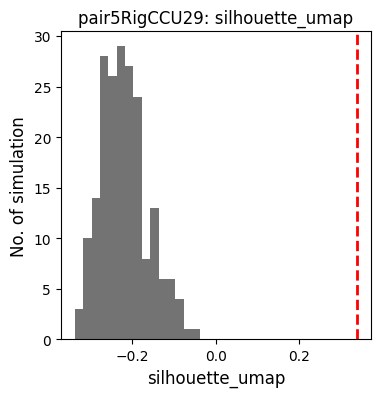

In [42]:
field = 'silhouette_umap'
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 4])
d = metrics[field]
bin_width = 0.02
bins = np.arange(min(d), max(d) + bin_width, bin_width)
ax.hist(d, bins=bins, color='#737373', edgecolor='none')
# add a line for the real data
ax.axvline(x=metric_r[field][0], color='red', linestyle='--', linewidth=2)
ax.set_xlabel(field, fontsize=12)
ax.set_ylabel('No. of simulation', fontsize=12)
ax.set_title(f'{bd}: {field}', fontsize=12)
# save as pdf
fn_pdf = os.path.join(fd_save, f'random.hist.{field}.pdf')
fig.savefig(fn_pdf)

### Plot an example random embedding 

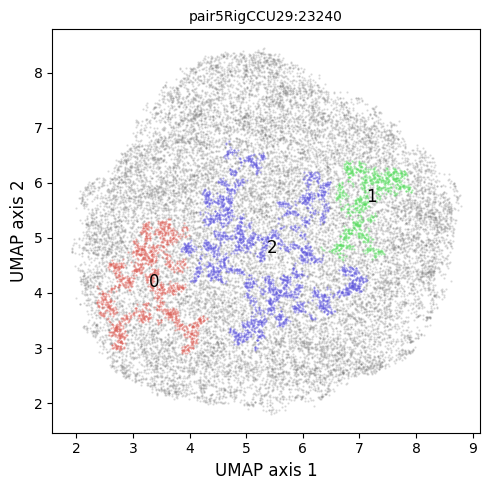

In [43]:
# color calls according to hdbscan labels
col_long = sns.color_palette('hls', n_colors=max(clusterer.labels_)+1)
# plot embedding
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5, 5])
for hi in range(-1, max(clusterer.labels_)+1):
    idx = np.where(clusterer.labels_ == hi)[0]
    embed_s = res[idx,:]
    if hi==-1:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.25, color='#737373')
    else:
        ax.scatter(embed_s[:,0], embed_s[:,1], s=0.3, alpha=0.5, color=col_long[hi])
        # add syl label
        ax.text(np.mean(embed_s[:,0]), np.mean(embed_s[:,1]), hi, fontsize=12)
ax.set_title(f'{bd}:{info.shape[0]}', fontsize=10)
ax.set_xlabel('UMAP axis 1', fontsize=12)
ax.set_ylabel('UMAP axis 2', fontsize=12)
plt.tight_layout()
# save fig
fn_fig = os.path.join(fd_save, f'{bd}.random.UMAPonVAE.HBBSCAN.pdf')
fig.savefig(fn_fig)

In [44]:
# save the embedding data to plot in Matlab 
embed_r = info.copy()
# save the latent features
for ii in range(latent_rd.shape[1]):
    embed_r[f'vae{ii}'] = latent_rd[:,ii]
# save the UMAP and HDBSCAN results
for ii in range(res.shape[1]):
    embed_r[f'umap{ii+1}'] = res[:,ii]
embed_r['hdbscan_cluster'] = clusterer.labels_+1
embed_r['hdbscan_prob'] = clusterer.probabilities_
fn_csv = os.path.join(fd_save, f'{bd}.random.embedding.csv')
embed_r.to_csv(fn_csv)

In [33]:
print(fn_csv)

/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair5RigCCU29/UMAPonVAE7/v/spec_goffinet_nn_256_176/pair5RigCCU29.random.embedding.csv


In [34]:
embed_r.shape

(23240, 43)